# Import Packages

In [1]:
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pyvis.network import Network
from netgraph import Graph
from julia import Julia
from matplotlib.lines import Line2D
import matplotlib.font_manager as fm

# Modularity Formulations

In [2]:
jl = Julia(runtime='C:/Users/blake/AppData/Local/Programs/Julia 1.5.3/bin/julia.exe') # path to julia 

julia_code = """
using JuMP, Gurobi, LinearAlgebra

function make_sequenced_modules(A,n_m,topic_sizes,max_size,min_size,review,review_sizes,time_limit)
    # A = topic dependency matrix
    # n_m = number of modules
    # topic_sizes = sizes of topics
    # max_size = maximum size of module
    # min_size = minimum size of module
    # review = binary review matrix if topic i is reviewed to teach topic j
    # review_sizes = size of reviewing topic i to teach topic j

    n_t = length(A[1,:]) # number of topics
    m = sum(A)
    
    if (n_t - n_m) % 2 == 0
        M = ((n_t - n_m + 2) / 2)^2
    else
        M = ((n_t - n_m + 1) / 2)^2 + ((n_t - n_m + 1) / 2)
    end

    mm=Model(optimizer_with_attributes(Gurobi.Optimizer,"TimeLimit"=>time_limit))

    @variable(mm, x[1:n_t,1:n_m], Bin) # module population matrix

    @constraint(mm, [i in 1:n_t], sum(x[i,p] for p in 1:n_m)==1) # each topic is assigned to one modules
    @constraint(mm, [p in 1:n_m], sum(x[i,p] for i in 1:n_t)>=1) # ecach module has at least one topic
    
    @variable(mm, module_size[1:n_m]) # size of each module
    @variable(mm, r[1:n_t,1:n_t,1:n_m], Bin) # if a topic i is reviewed in module p to teach topic j
    
    @constraint(mm, [i in 1:n_t,j in 1:n_t,p in 1:n_m], r[i,j,p] == x[i,p] * (1 - x[j,p]) * review[j,i])
    @constraint(mm, [p in 1:n_m], module_size[p] == sum(x[i,p] * topic_sizes[i] for i in 1:n_t) + sum(review_sizes[i,j] * r[i,j,p] for j in 1:n_t for i in 1:n_t if i != j)) # calculate the size of each module
    @constraint(mm, [p in 1:n_m], min_size <= module_size[p] <= max_size) # each module is size restricted

    @objective(mm, Max, 1/2/m*sum(A[i,j]*x[i,t]*x[j,t] for i in 1:n_t for j in 1:n_t for t in 1:n_m)) # maximize modularity 

    @variable(mm, B[1:n_m,1:n_m], Int) # matrix of number of edges between modules

    @constraint(mm, B .== transpose(x)*A*x)

    @variable(mm, C[1:n_m,1:n_m], Bin) # matrix representing directed edges between modules

    for p in 1:n_m
        for q in 1:n_m
            if p != q
                @constraint(mm, C[p,q] >= B[p,q] / M)
                @constraint(mm, C[p,q] <= B[p,q])
            else
                @constraint(mm, C[p,q] == 0)
            end
        end
    end

    @variable(mm, D[1:n_m,1:n_m,1:n_m]) # matrix showing the modules accessed depending on the number of steps

    for L in 1:n_m
        for p in 1:n_m
            for q in 1:n_m
                if L == 1
                    @constraint(mm, D[p, q, L] == C[p, q])
                else
                    @constraint(mm, D[p, q, L] == sum(D[p, k, L-1] * C[k, q] for k in 1:n_m))
                end
            end
        end
    end

    @variable(mm, E[1:n_m,1:n_m]) # matrix showing paths from module to module

    @constraint(mm, E .== sum(D[:,:,i] for i in 1:n_m)) 

    @variable(mm, F[1:n_m,1:n_m], Bin) # matrix representing if there is a path from one node to another

    for p in 1:n_m
        for q in 1:n_m
            @constraint(mm, F[p,q] >= E[p,q] / 2^(n_m-2))
            @constraint(mm, F[p,q] <= E[p,q])
        end
    end

    for p in 1:n_m
        for q in 1:n_m
            @constraint(mm, F[p,q] + F[q,p] <= 1)
        end
    end

    optimize!(mm)

    X = value.(x)
    X_bool = X .> 0
    groups = [findall(X_bool[:,p]) for p in 1:n_m]
    modules = convert(Array{Any}, [convert(Array{Any},group) for group in groups])
    
    R = value.(r)
    R_bool = R .> 0
    
    reviews = []
    for p in 1:n_m
        for i in 1:n_t
            for j in 1:n_t
                if R_bool[i, j, p]
                    push!(reviews, (i,j,p))
                end
            end
        end
    end

    modularity = JuMP.objective_value(mm)

    return (modules, modularity, reviews)
    
end
"""

jl.eval(julia_code)

C:\Users\blake\Anaconda3\lib\site-packages\julia\core.py:709: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


<PyCall.jlwrap make_sequenced_modules>

# Load and Process Data to Build Graph

In [3]:
courses = ['CBE 320', 'CBE 326', 'CBE 426']
course_names = ['Intro Transport Phenomena','Momentum and Heat Transfer','Mass Transfer Operation']
credits = [4, 3, 3]

course_names = dict(zip(courses,course_names)) # dictionary of course names
graph = nx.DiGraph() # initialize an empty directed graph

topic_sizes = {} # dictionary of topic sizes
topic_courses = {} # dictionary of store topic-course mapping
review_sizes = {} # dictionary of review times between topics
reviewed_topics = [] # list of topics that are reviewed
course_topics = {} # dictionary of all new topics introduced in a course
topic_course_sizes = {} # size of each topic in each course
simple_review_sizes = {} # dictionary of review sizes not indexed by course
weighted_review_sizes = {} # simple review size / number of sucessors in course it is reviewed in
topic_type = {} # topic transport type

for p,course in enumerate(courses):
    course_data = pd.read_csv('../Data/'+str(course)+'.csv', encoding='unicode_escape') # get course data
    new_topics = []
    for index, row in course_data.iterrows(): # iterate over each row
        i = row['Topic']
        edges_to = row['Edges To']  
        size = row['Size']
        topic_type[i] = [row['Type']]
        
        if i in topic_sizes:
            reviewed_topics.append(i)
        
        if not graph.has_node(i): # add node for topic if not already present
            graph.add_node(i, size=size)

        if pd.notnull(edges_to): # check if there are any edges to 
            edges_to = [topic.strip() for topic in edges_to.split(';')] # split edges_to
            num_rev = len(edges_to)

            for j in edges_to: # iterate over edges to 
                graph.add_edge(i, j) # add edge from i to j

                if i in topic_sizes: # add review time only if the topic has been taught in a previous course
                    review_sizes[i,j,p] = size
                    simple_review_sizes[i,j] = size
                    weighted_review_sizes[i,j] = size/num_rev

        if i not in topic_courses: # add info for a new topic 
            topic_courses[i] = [course]
            topic_sizes[i] = size
            new_topics.append(i)
            topic_course_sizes[i] = [size]
        else:
            topic_courses[i].append(course)
            topic_course_sizes[i].append(size)
            
    course_topics[course] = new_topics

reviewed_topics = list(set(reviewed_topics))

inter_data = pd.read_csv('../Data/Inter Connections.csv', encoding='unicode_escape') 

for index, row in inter_data.iterrows(): # add inter-course edges
    i = row['Topic']
    if i in topic_sizes.keys():
        edges_to = row['Edges To']
        if pd.notnull(edges_to): # check if there are any edges to
            edges_to = [topic.strip() for topic in edges_to.split(';')] # split edges_to 
            for j in edges_to: # iterate over edges_to
                if j in topic_sizes.keys():
                    graph.add_edge(i,j) # add edge from topic i to topic j
            
if not nx.is_directed_acyclic_graph(graph): # check if graph is directed and acyclic
    print("Not directed acyclic")

# Functions

In [4]:
def make_sequenced_modules(n_m, max_size, min_size, time_limit): # make sequenced modules of a specific size
    A = nx.to_numpy_array(graph)
    nodes = list(graph.nodes(data=False))
    n_t = len(nodes)
    sizes = [topic_sizes[i] for i in nodes]
    node_dict = dict(zip(range(1,n_t+1),nodes)) # dictionary used for communication between python and julia
    
    # rewrite data for julia format
    review = np.zeros([n_t,n_t])
    review_size = np.zeros([n_t,n_t])
    for ii,i in enumerate(nodes):
        for jj, j in enumerate(nodes):
            if (i,j) in weighted_review_sizes.keys():
                review[jj,ii] = 1
                review_size[ii,jj] = weighted_review_sizes[i,j] 

    julia_A = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in A) + "]"
    julia_review = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in review) + "]"
    julia_review_size = "[" + "; ".join("[" + " ".join(map(str, row)) + "]" for row in review_size) + "]"

    (modules,modularity,reviews) = jl.eval(f"make_sequenced_modules({julia_A},{n_m},{sizes},{max_size},{min_size},{julia_review},{julia_review_size},{time_limit})") # send to julia
    
    # rewrite results for python format
    review_list = []
    for review in reviews:
        review_list.append([node_dict[review[0]],node_dict[review[1]]])
                    
    for i in range(len(modules)):
            for j in range(len(modules[i])):
                    modules[i][j] = node_dict[modules[i][j]]
                    
    return (modules,modularity,review_list)

def calc_modularity(modules): # calculate the modularity of the modules in the graph
    nodes = list(graph.nodes())
    A = nx.to_numpy_array(graph)
    
    n_nodes = len(nodes)
    n_modules = len(modules)
    
    x = np.zeros((n_nodes,n_modules))    
    for p, module in enumerate(modules):
        for i in module:
            ii = nodes.index(i)
            x[ii,p] = 1
    
    m = sum(sum(A))
    
    modularity = 1/2/m*sum(A[i,j]*x[i,p]*x[j,p] for i in range(n_nodes) for j in range(n_nodes) for p in range(n_modules))
    
    return modularity

def process_modules(modules,reviews): # unpack results of new modules
    topic_modules = {}
    topic_module_sizes = {}
    for p, topics in enumerate(modules):
        for i in topics:
            topic_modules[i] = [p]
            topic_module_sizes[i] = [topic_sizes[i]]

    # see which topics are reviewed in the new modules
    module_review_sizes = {}
    module_reviewed_topics = []
    for review in reviews:
        i = review[0]
        j = review[1]
        p = topic_modules[j][0]
        module_review_sizes[i,j,p] = simple_review_sizes[i,j]
        if i not in module_reviewed_topics:
            module_reviewed_topics.append(i)
        if p not in topic_modules[i]:
            topic_modules[i].append(p)
            topic_module_sizes[i].append(simple_review_sizes[i,j])
    
    # determine module sizes
    module_size = []
    for p,topics in enumerate(modules):
        size = 0
        topics_checked = []
        for i in topics:
            size += topic_sizes[i]
            for j in graph.nodes():
                if (j,i,p) in module_review_sizes.keys() and j not in topics_checked:
                    size += module_review_sizes[j,i,p]
                    topics_checked.append(j)

        module_size.append(size)
                            
    return (topic_modules, topic_module_sizes, module_size, module_review_sizes, module_reviewed_topics)

def total_review_size(topic_module_sizes): # calculate total review size of modules
    size = sum([sum(topic_module_sizes[i][1:]) for i in graph.nodes()])  
    
    return size

def graph_module_nodes(pos,module_colors,topic_modules,topic_module_sizes,filename): # create a graph of modules with coloring for reviews
    figure = plt.figure(figsize=(40,40))
    
    edge_color = [module_colors[topic_modules[edge[0]][0]] for edge in list(graph.edges())]
    node_size_module = [sum(topic_module_sizes[i]) for i in graph.nodes()]
    nx.draw(graph, pos, node_size=[8000*v for v in node_size_module], node_color='#FFFFFF',
            arrowsize=30, width=4, edge_color=edge_color)
    layers = max([len(value) for value in topic_modules.values()])
    
    for q in range(layers-1,-1,-1):
        sizes = {}
        colors = {}
        for i in graph.nodes():
            if len(topic_modules[i]) - 1 >= q:
                colors[i] = module_colors[topic_modules[i][q]]
                size = sum(topic_module_sizes[i][0:q+1])
            else: 
                size = topic_sizes[i]
                colors[i] =  module_colors[topic_modules[i][0]]
            
            sizes[i] = size
        nx.draw_networkx_nodes(graph, pos, node_size=[8000*v for v in sizes.values()],node_color=[v for v in colors.values()])
    figure.savefig(filename,format="pdf")
    
    return figure

def graph_base_nodes(pos,topic_module_sizes,filename):
    figure = plt.figure(figsize=(40,40))
    
    node_size = [sum(topic_module_sizes[i]) for i in graph.nodes()]
    nx.draw(graph, pos, node_size=[8000*v for v in node_size], node_color='#000000', arrowsize=30, width=4, edge_color='#000000')
    
    sizes = {}
    node_color = {}
    for i in graph.nodes:
        sizes[i] = topic_module_sizes[i][0]
        successors = list(graph.successors(i))
        predecessors = list(graph.predecessors(i))
        connections = len(successors) + len(predecessors)
        node_color[i] = '#6F8FAF'
        if len(successors) == 0:
            node_color[i] = '#D2042D'
        if len(predecessors) == 0:
            node_color[i] = '#008000'
        if connections == 0:
            node_color[i] = '#000000'
    
    nx.draw_networkx_nodes(graph, pos, node_size=[8000*v for v in sizes.values()],node_color=[v for v in node_color.values()])
    figure.savefig(filename,format="PDF")
    
    return figure

# Visualize Graph

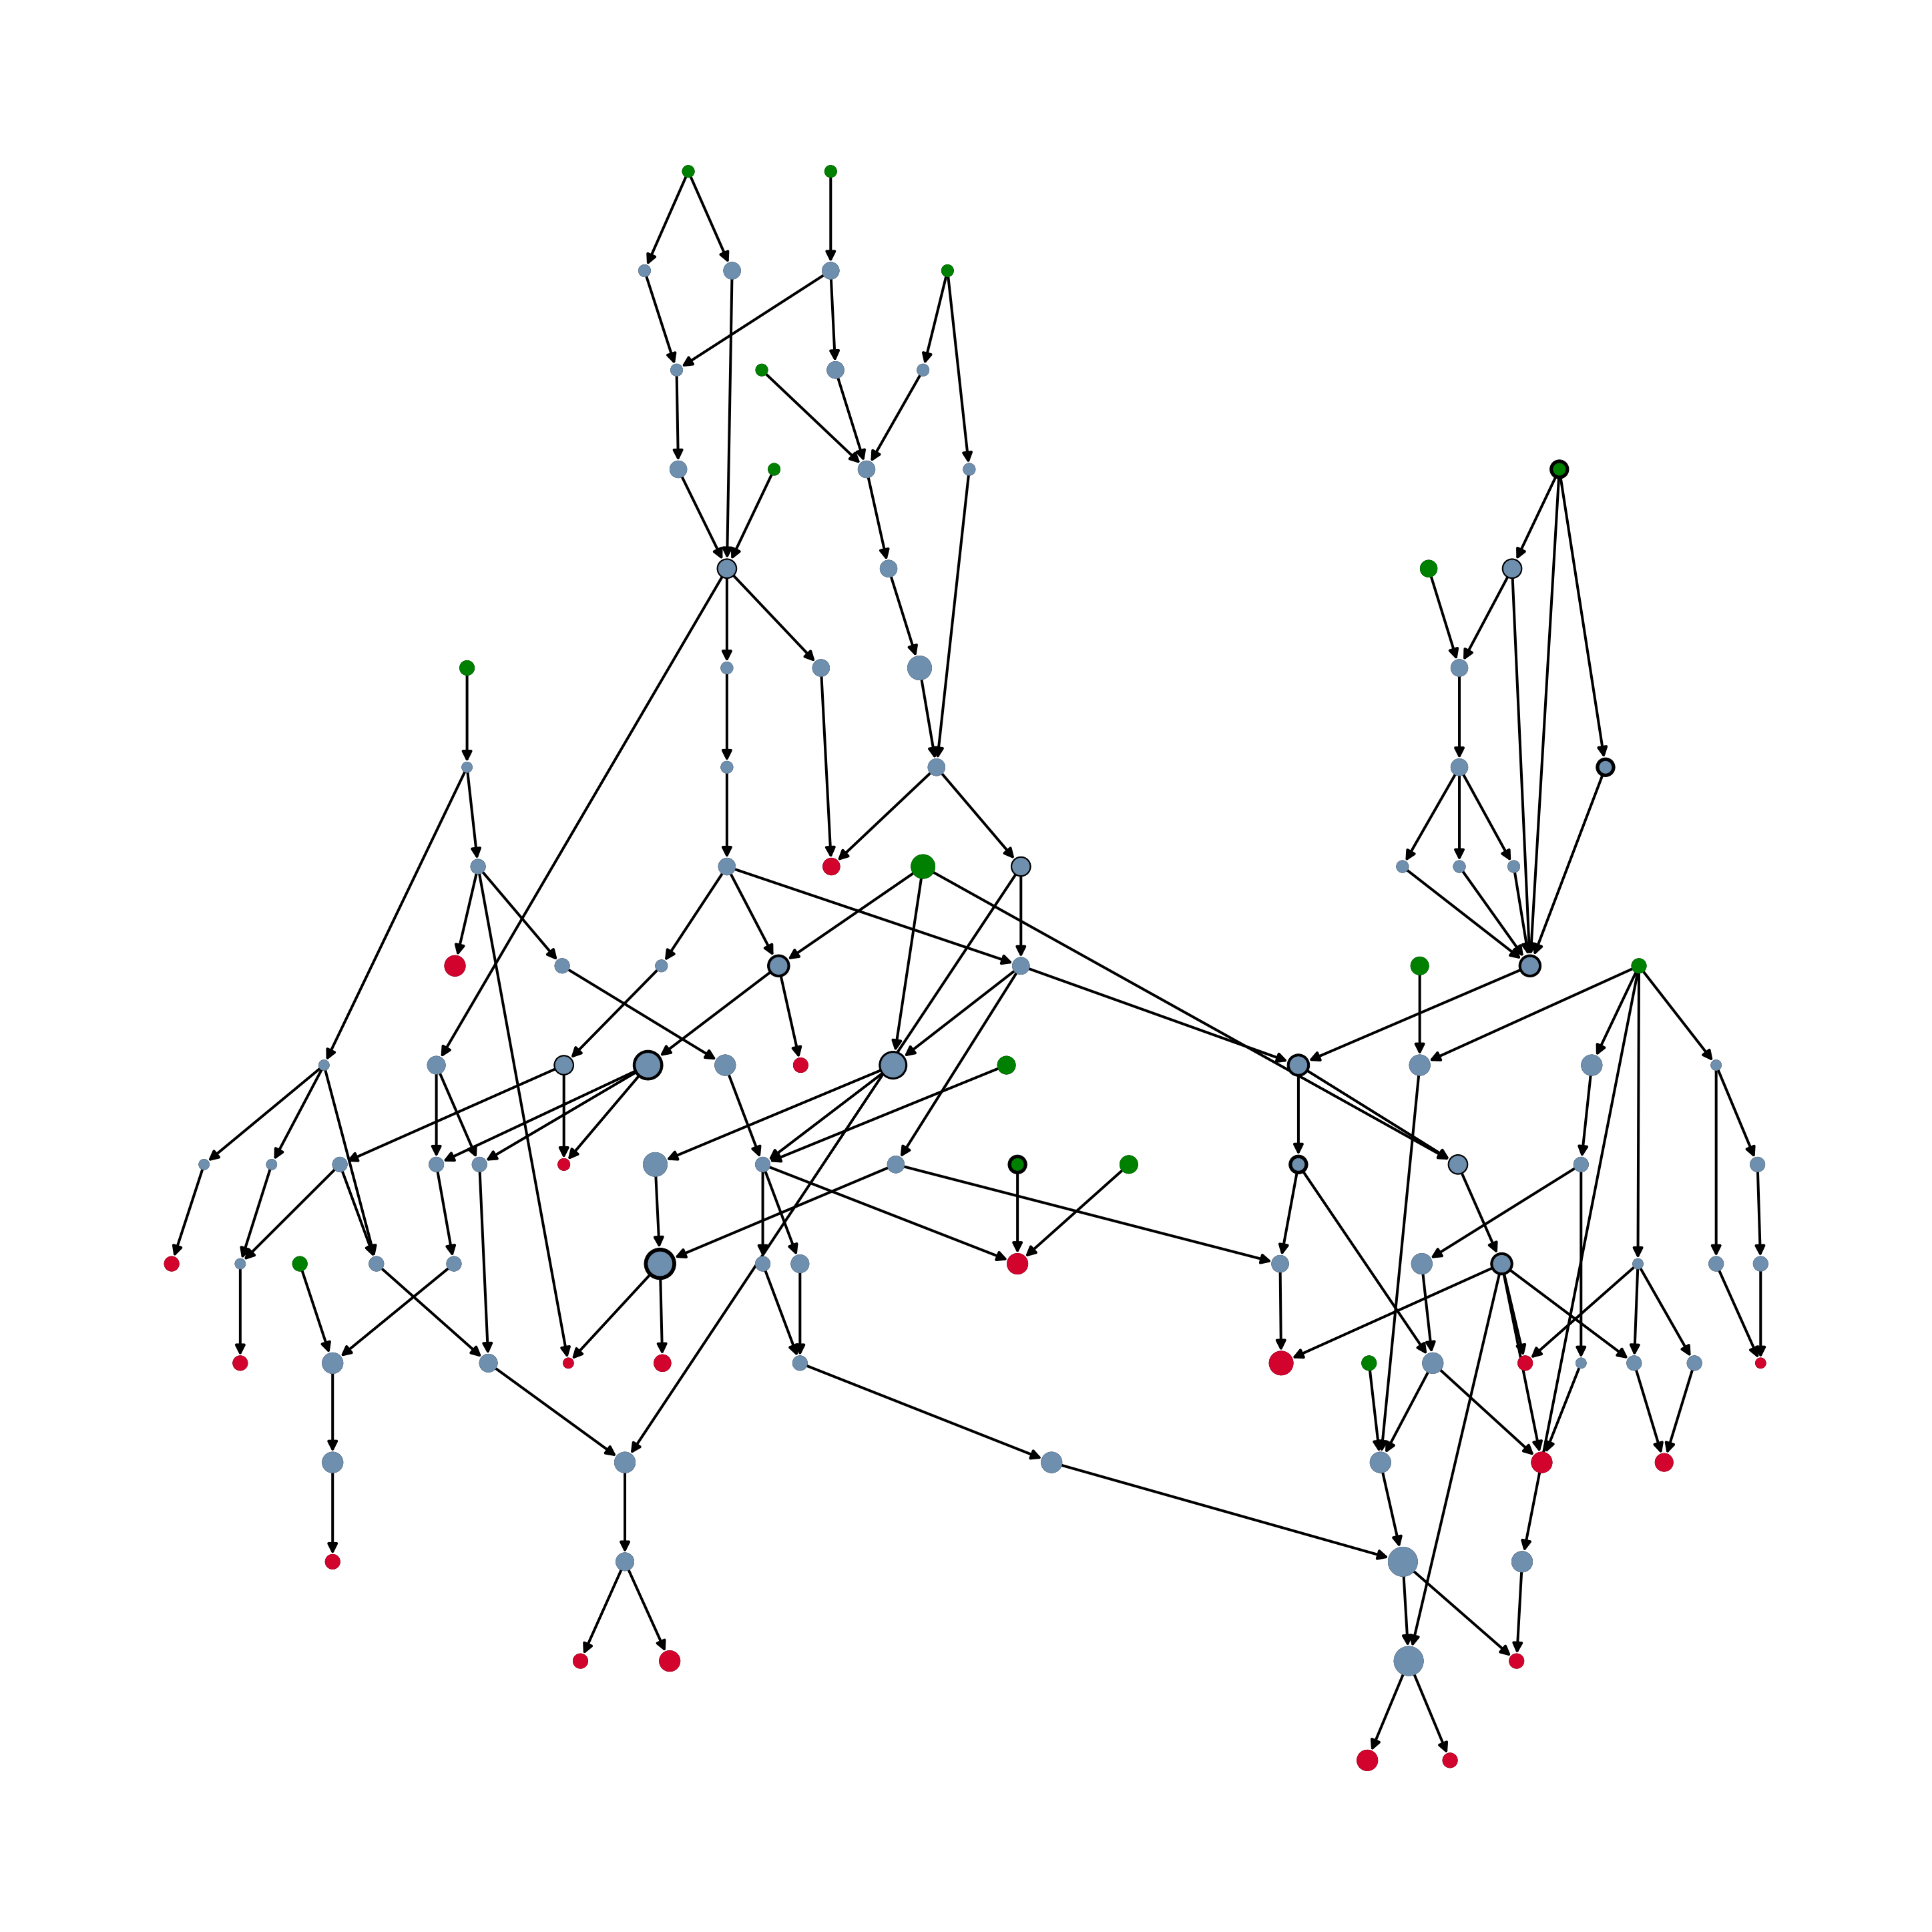

In [5]:
pos_base = nx.nx_agraph.graphviz_layout(graph,prog='dot', args='-Grankdir=TB -Granksep=equally -Gnodesep=equally -Grank=max')

base_figure = graph_base_nodes(pos_base,topic_course_sizes,"../Transport Graphs/Transport Topics.pdf")

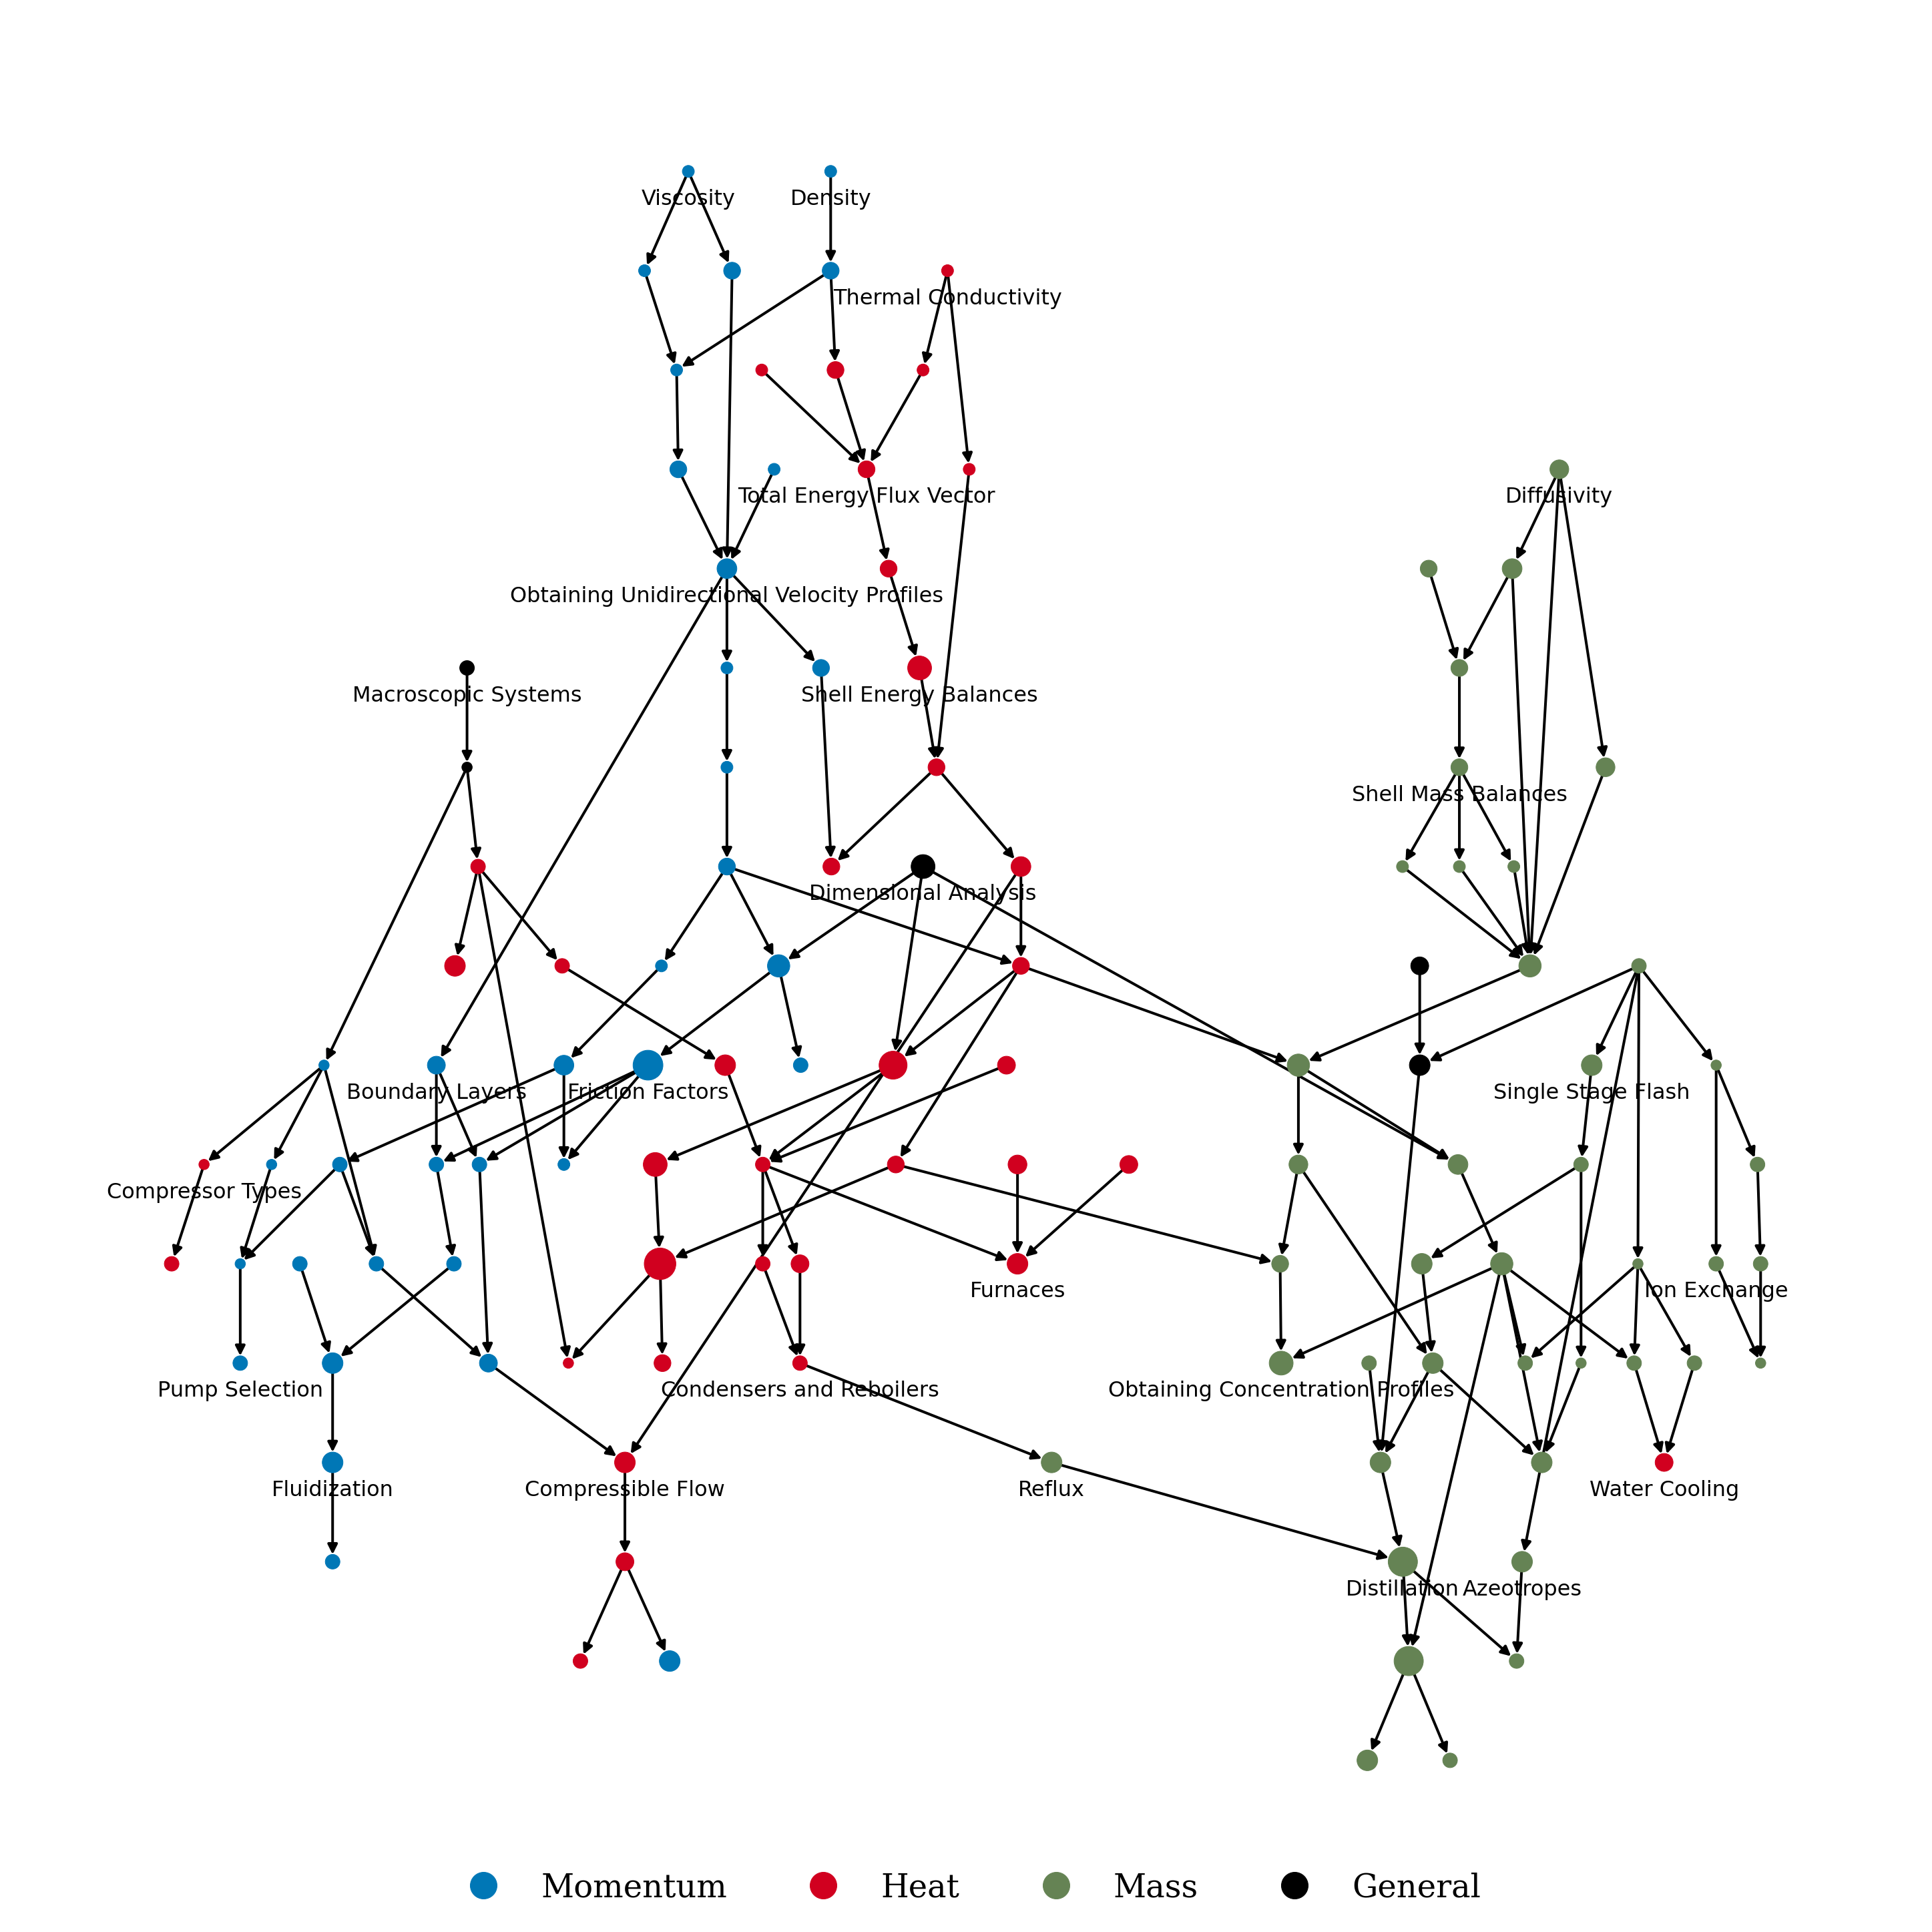

In [6]:
type_figure = plt.figure(figsize=(40,40))
type_modules = [[],[],[],[]]
node_size = [sum(topic_course_sizes[i]) for i in graph.nodes()]
node_color = {}
for i in graph.nodes:
    if topic_type[i][0] == 'Momentum':
        node_color[i] = '#0077B6'
        type_modules[0].append(i)
    elif topic_type[i][0] == 'Heat':
        node_color[i] = '#D1001F'
        type_modules[1].append(i)
    elif topic_type[i][0] == 'Mass':
        node_color[i] = '#658354'
        type_modules[2].append(i)
    else:
        node_color[i] = '#000000'
        type_modules[3].append(i)
names = ['Momentum','Heat','Mass','General']
type_colors = dict(zip(names,['#0077B6','#D1001F','#658354','#000000']))

nx.draw(graph, pos_base, node_size=[8000*v for v in node_size], node_color=[v for v in node_color.values()], arrowsize=30, width=4, edge_color='#000000')

label_pos = {}
for node in graph.nodes:
    label_pos[node] = (pos_base[node][0], pos_base[node][1] - 20)
    
nodes_to_label = ['Viscosity','Density','Thermal Conductivity','Diffusivity','Dimensional Analysis','Compressor Types','Macroscopic Systems','Boundary Layers','Friction Factors','Furnaces','Distillation','Single Stage Flash','Azeotropes','Adsoprtion Equipment','Obtaining Concentration Profiles','Water Cooling','Reflux','Compressible Flow','Obtaining Unidirectional Velocity Profiles','Total Energy Flux Vector','Condensers and Reboilers','Shell Mass Balances','Fluidization','Pump Selection','Ion Exchange','Shell Energy Balances']
labels_to_display = {node: node for node in nodes_to_label if node in graph.nodes}
labels = nx.draw_networkx_labels(graph, label_pos,labels=labels_to_display, font_size=32, font_family='sans-serif')

legend_elements = [Line2D([0], [0], marker='o', color=type_colors[t], label=t, lw=0,markerfacecolor=type_colors[t], markersize=40) for t in names]
font_props = fm.FontProperties(family='serif', size=48)
type_figure.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=4,prop=font_props)

type_figure.savefig("../Transport Graphs/Transport Topics-Type.pdf",format="pdf")

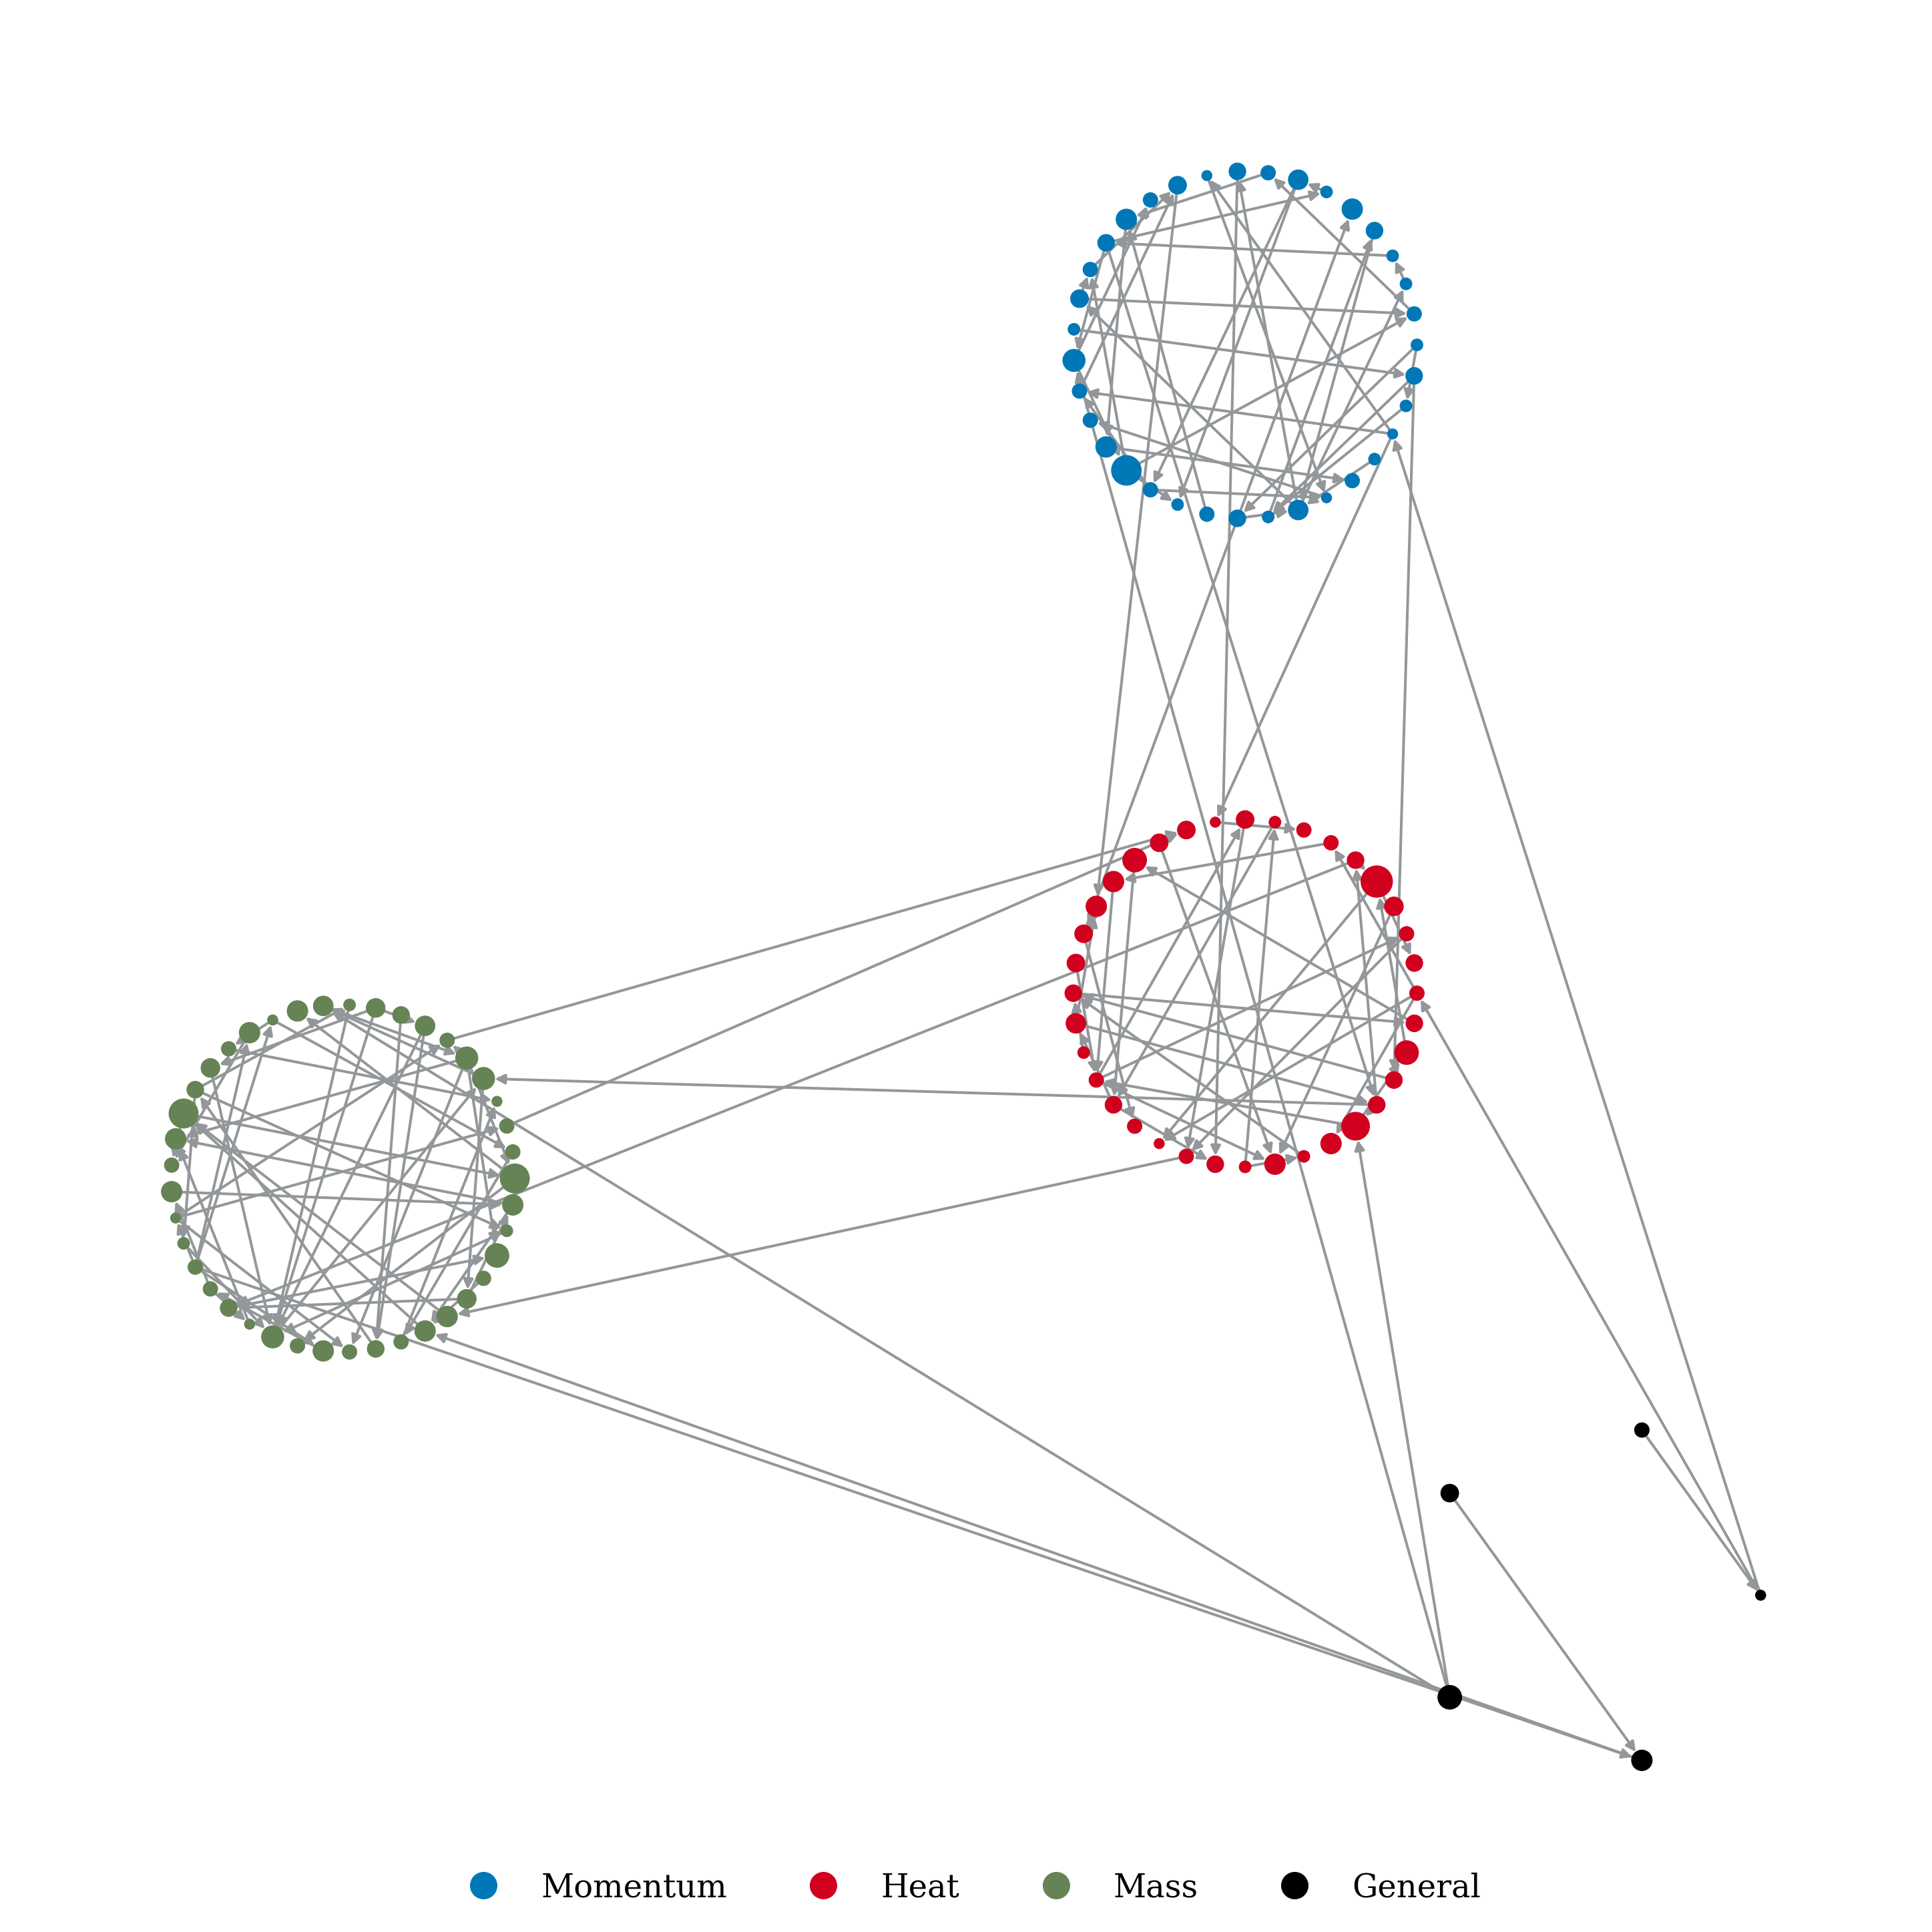

In [7]:
hypergraph = nx.DiGraph()
for k, (i, j) in enumerate(graph.edges()):
    p = topic_type[i][0]
    q = topic_type[j][0]
    if p != q:
        hypergraph.add_edge(p, q)

hypergraph_pos = nx.nx_agraph.graphviz_layout(hypergraph, prog='dot')

hypergraph_pos['Heat'] = (hypergraph_pos['Heat'][0], hypergraph_pos['Heat'][1]-40)

pos_nodes = dict()
for topics in type_modules:
    subgraph = graph.subgraph(topics)
    pos_subgraph = nx.circular_layout(subgraph)
    pos_nodes.update(pos_subgraph)

pos_type = dict()
for topics in type_modules:
    for i in topics:
        pos_type[i] = (hypergraph_pos[topic_type[i][0]][0] + 4*pos_nodes[i][0], 
                       hypergraph_pos[topic_type[i][0]][1] + 30*pos_nodes[i][1]) 

type_figure_grouped = plt.figure(figsize=(40,40))

nx.draw(graph, pos_type, node_size=[8000*v for v in node_size], node_color=[v for v in node_color.values()], arrowsize=30, width=4, edge_color='#939799')

legend_elements = [Line2D([0], [0], marker='o', color=type_colors[t], label=t, lw=0,markerfacecolor=type_colors[t], markersize=40) for t in names]
font_props = fm.FontProperties(family='serif', size=48)
type_figure_grouped.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=4,prop=font_props)

type_figure_grouped.savefig("../Transport Graphs/Transport Topics-Type Grouped.pdf",format="pdf")

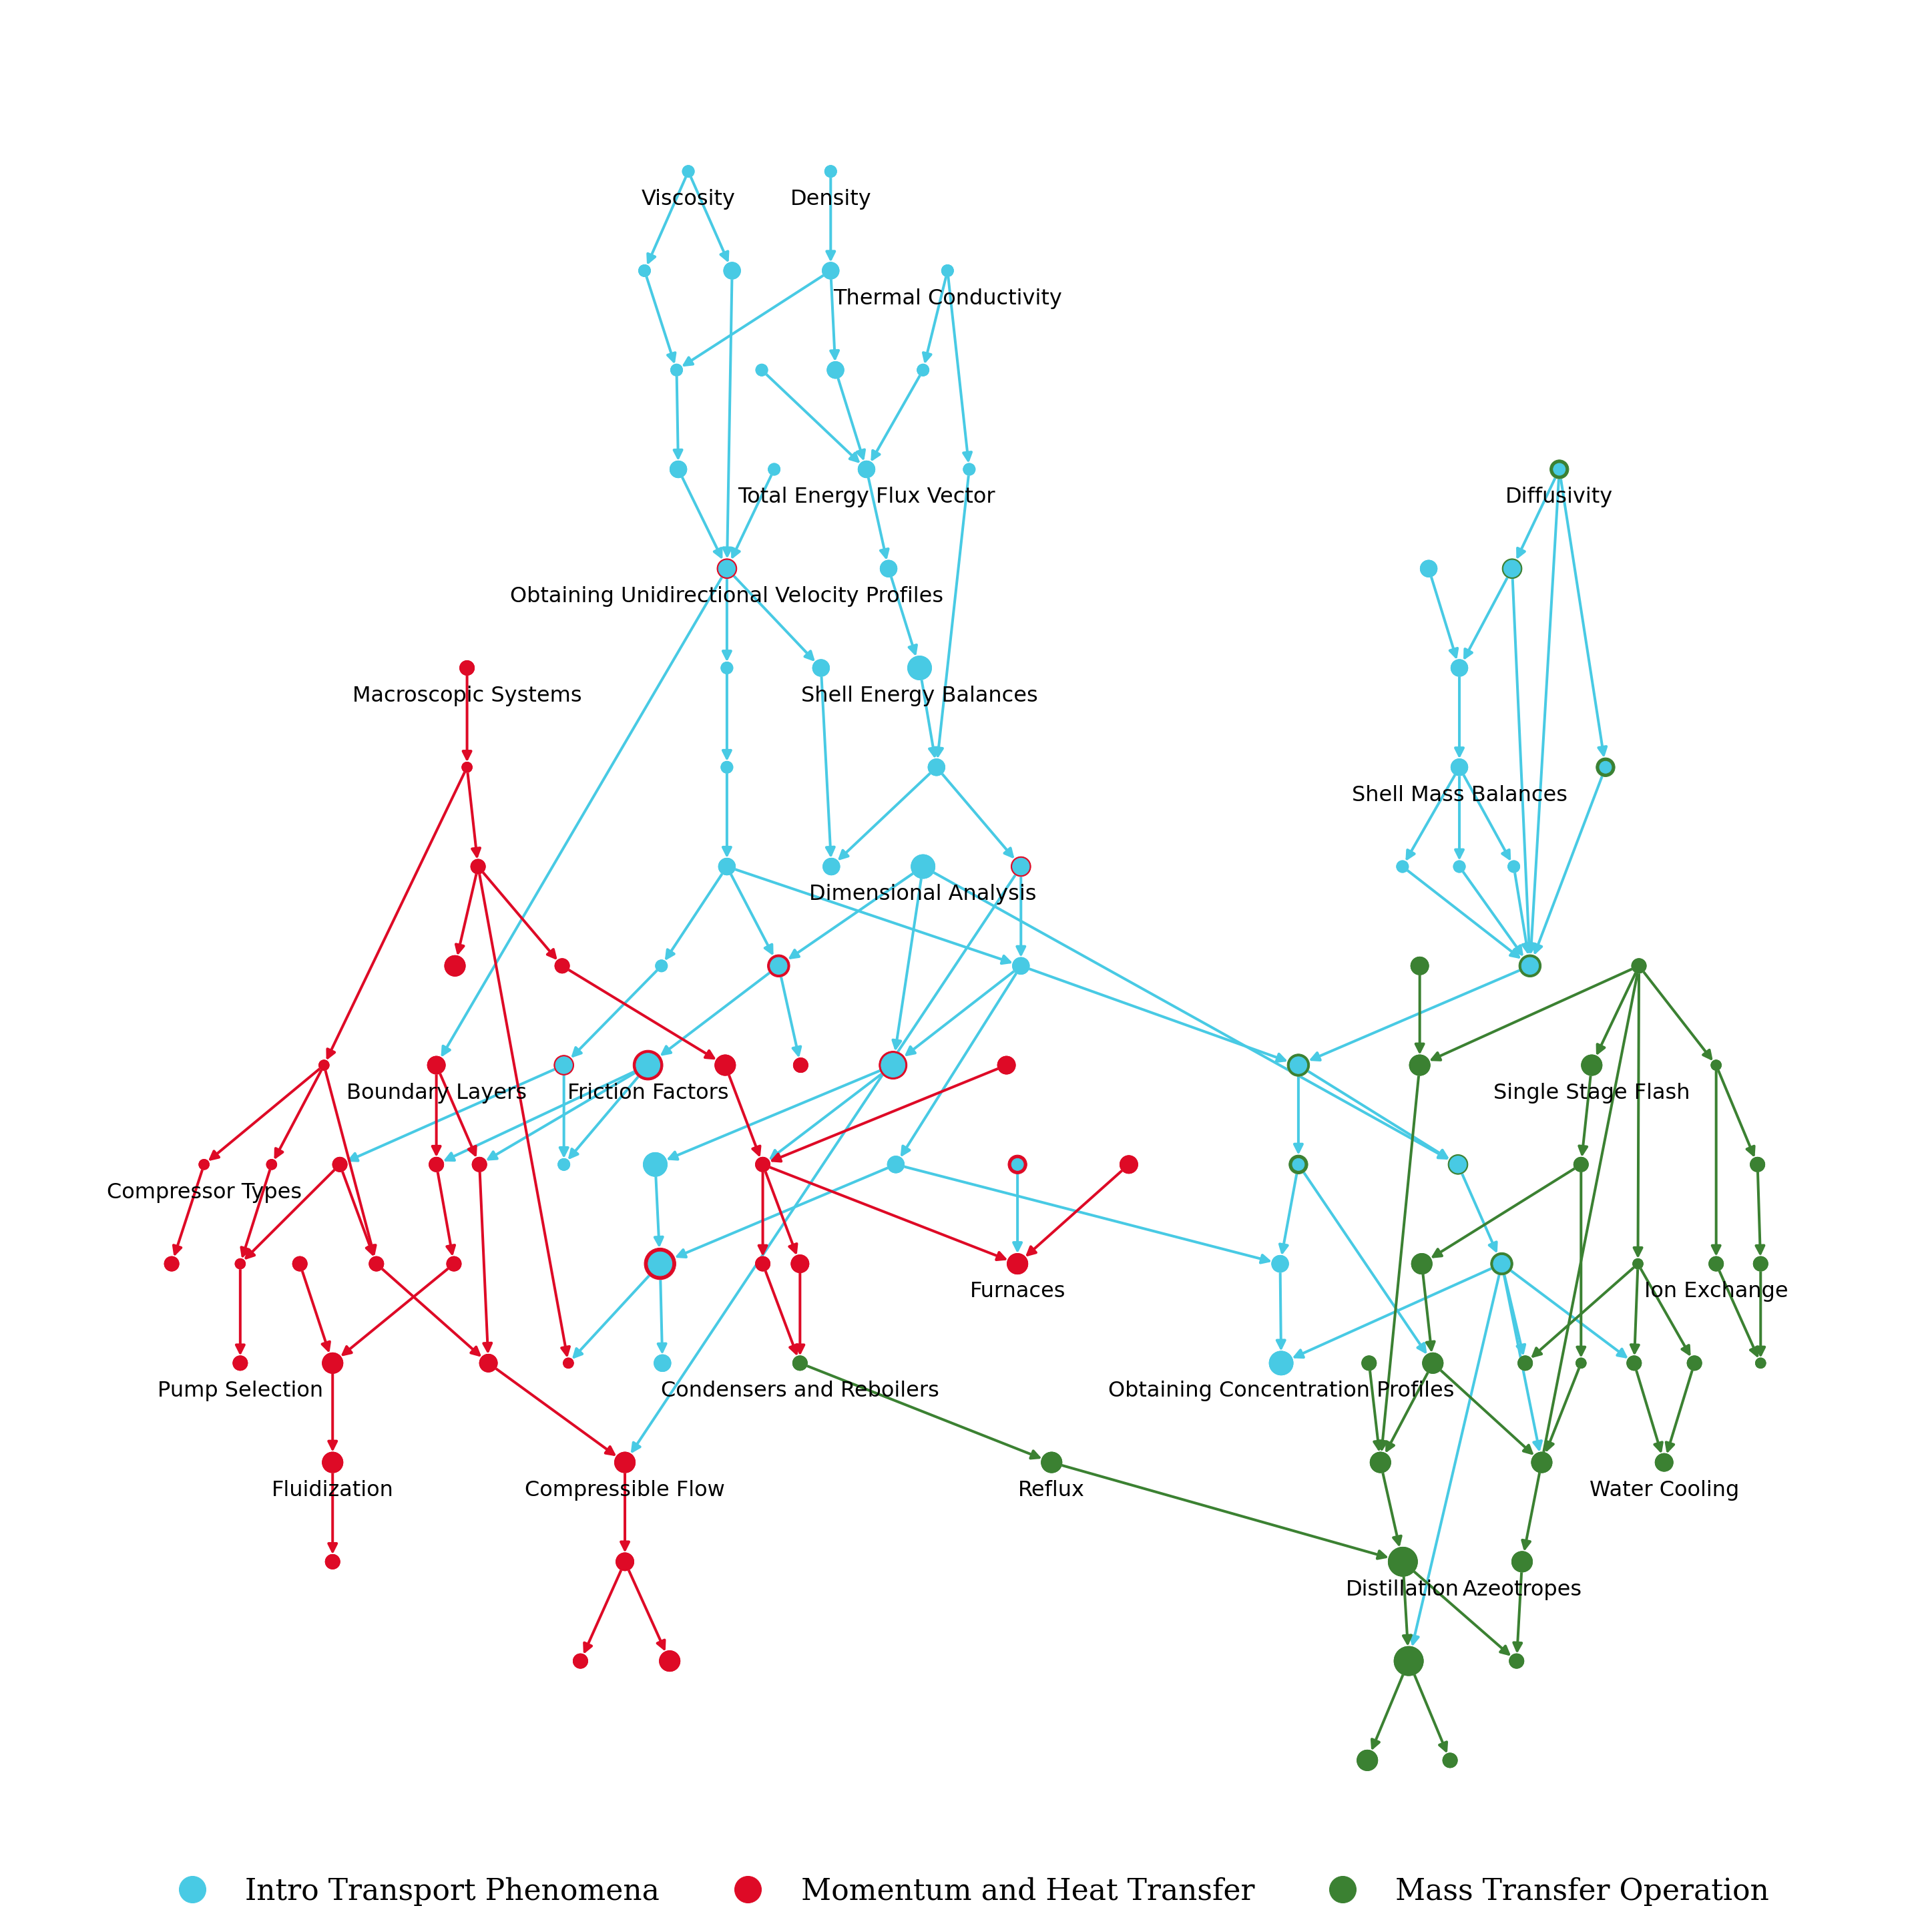

In [8]:
colors = ['#48cae4','#de0a26','#3b8132']
course_colors = dict(zip(courses,colors))

named_fig = graph_module_nodes(pos_base,course_colors,topic_courses,topic_course_sizes,"../Transport Graphs/Transport Topics-Courses.pdf")

label_pos = {}
for node in graph.nodes:
    label_pos[node] = (pos_base[node][0], pos_base[node][1] - 20)
    
nodes_to_label = ['Distillation','Viscosity','Density','Thermal Conductivity','Diffusivity','Dimensional Analysis','Compressor Types','Macroscopic Systems','Boundary Layers','Friction Factors','Furnaces','Distillation','Single Stage Flash','Azeotropes','Adsoprtion Equipment','Obtaining Concentration Profiles','Water Cooling','Reflux','Compressible Flow','Obtaining Unidirectional Velocity Profiles','Total Energy Flux Vector','Condensers and Reboilers','Shell Mass Balances','Fluidization','Pump Selection','Ion Exchange','Shell Energy Balances']
labels_to_display = {node: node for node in nodes_to_label if node in graph.nodes}
labels = nx.draw_networkx_labels(graph, label_pos,labels=labels_to_display, font_size=32, font_family='sans-serif')

legend_elements = [Line2D([0], [0], marker='o', color=course_color, label=course_names[course], lw=0,markerfacecolor=course_color, markersize=40) for course,course_color in course_colors.items()]
font_props = fm.FontProperties(family='serif', size=44)
named_fig.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=3,prop=font_props)
named_fig.savefig("../Transport Graphs/Transport Topics-Courses.pdf",format="pdf")

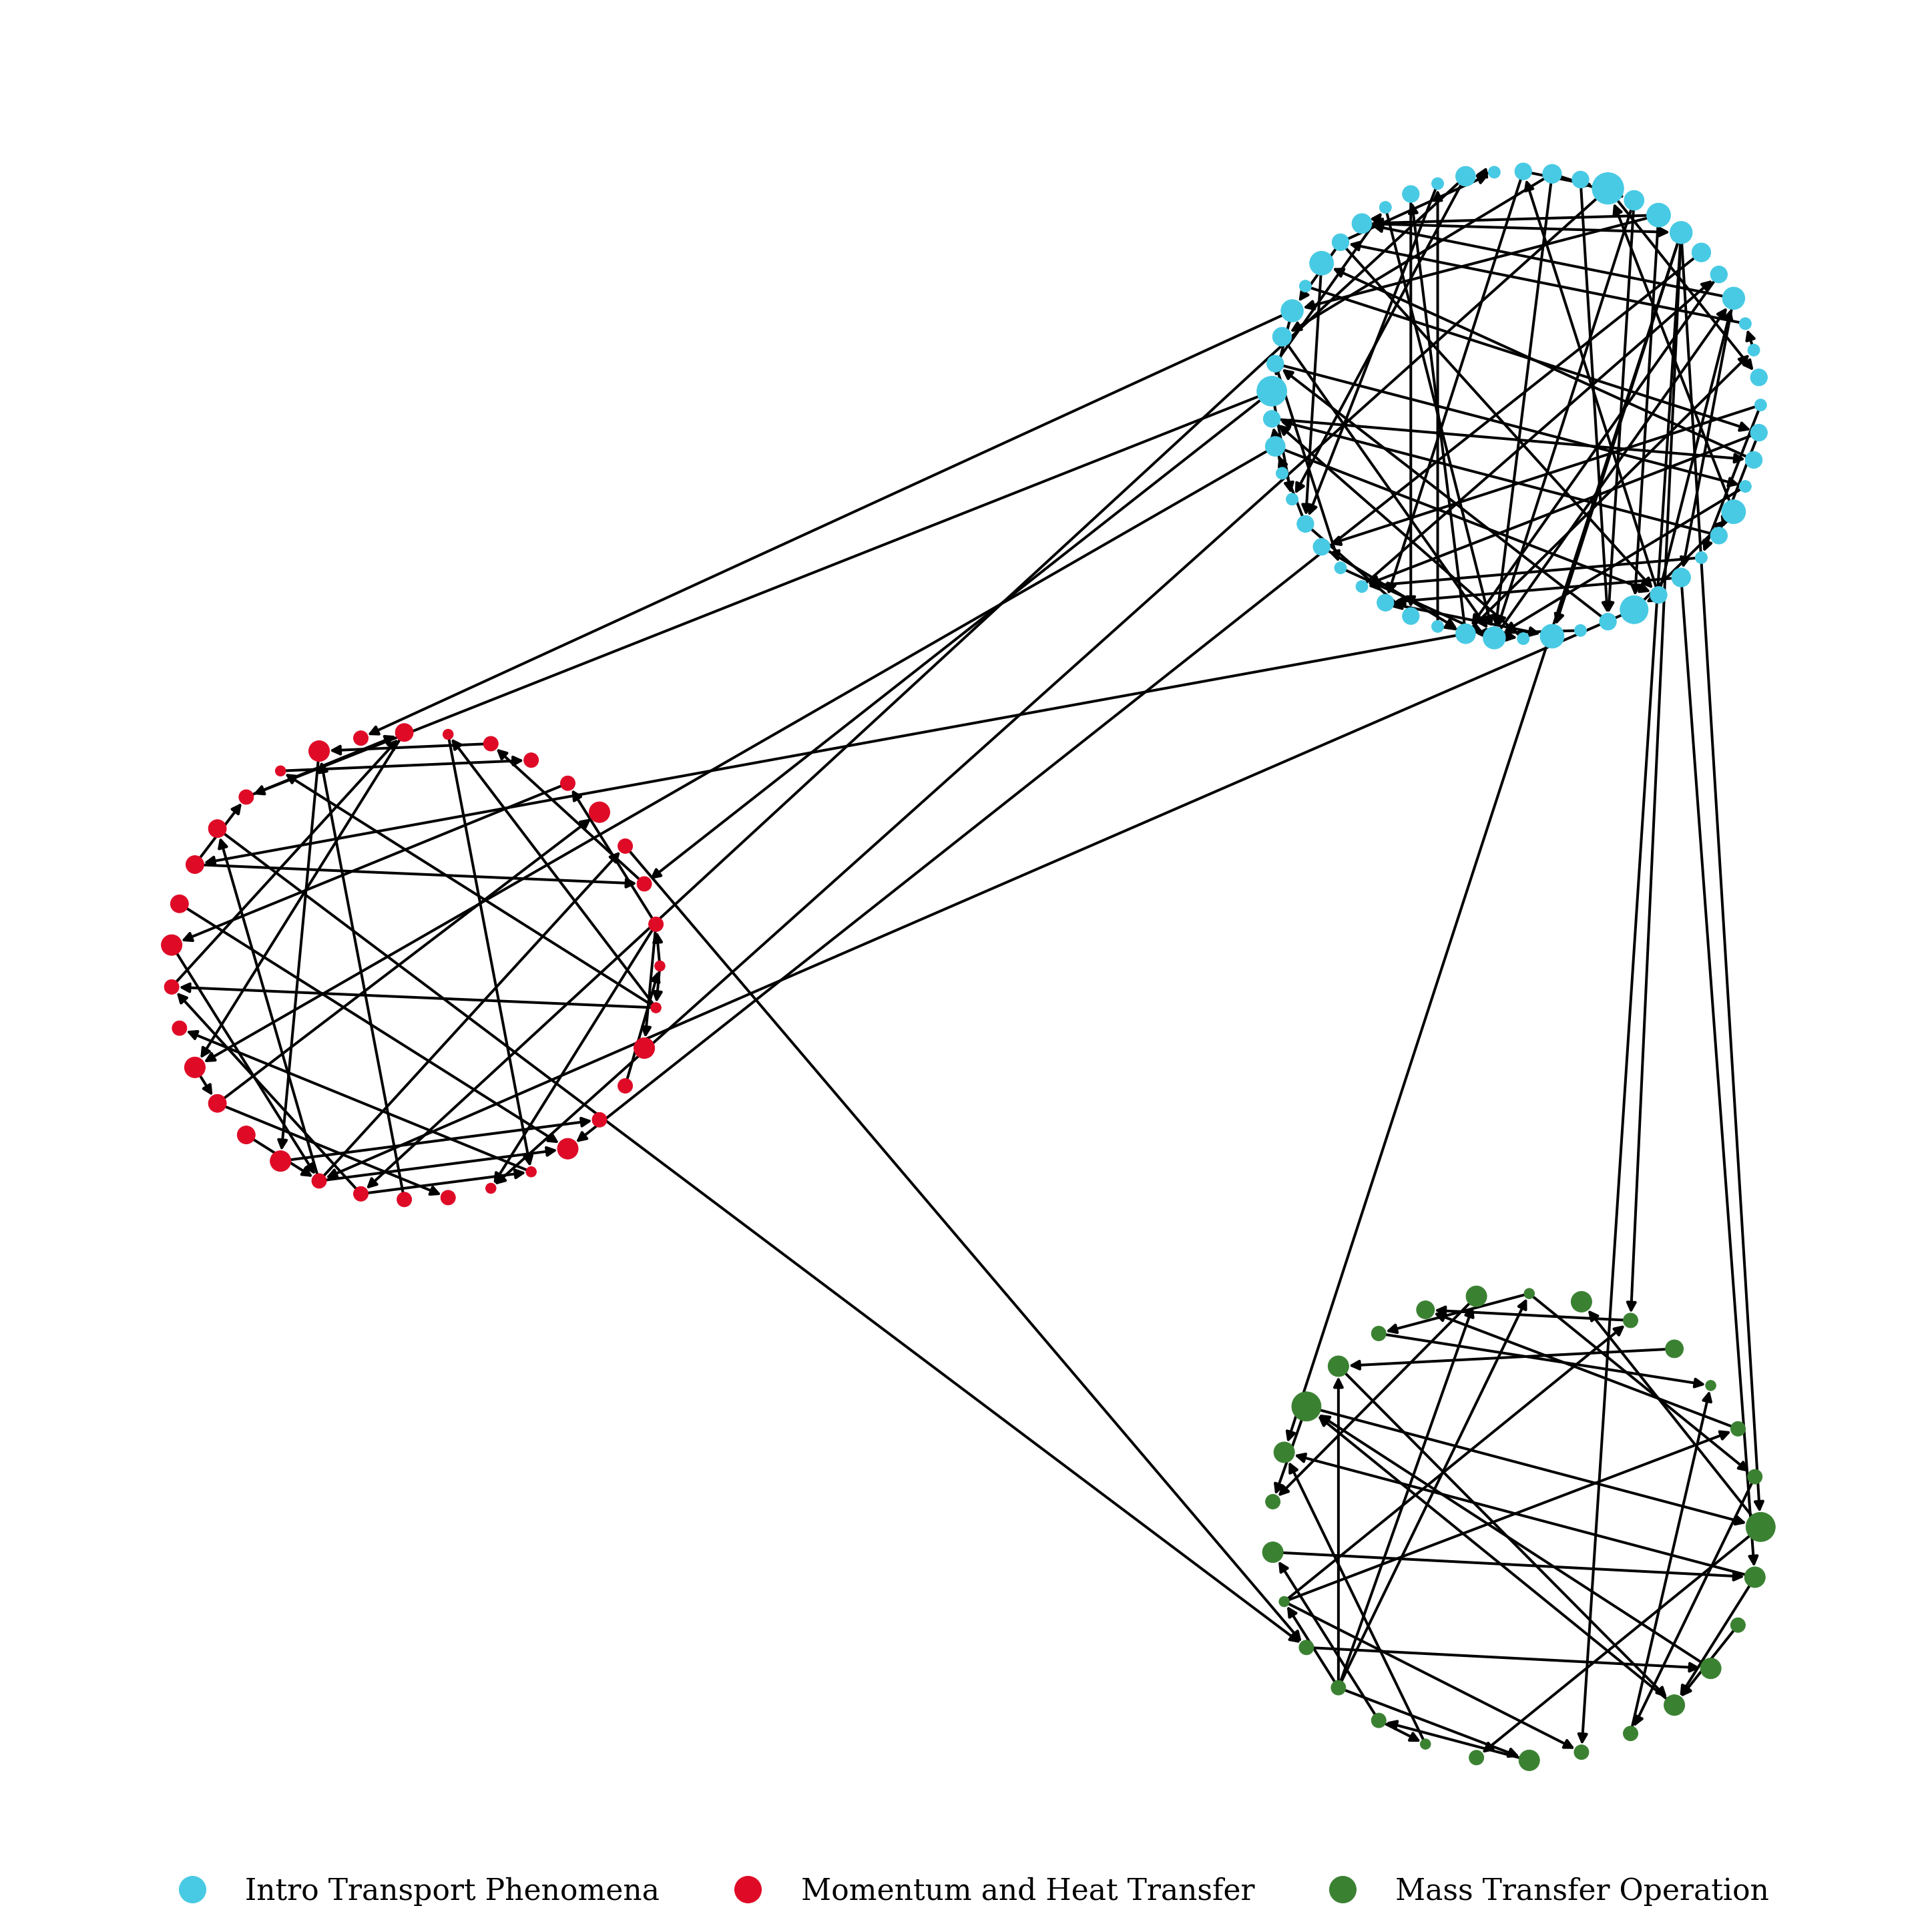

In [9]:
hypergraph = nx.DiGraph()
for k, (i, j) in enumerate(graph.edges()):
    p = topic_courses[i][0]
    q = topic_courses[j][0]
    if p != q:
        hypergraph.add_edge(p, q)

hypergraph_pos = nx.nx_agraph.graphviz_layout(hypergraph, prog='dot')

pos_nodes = dict()
for topics in list(course_topics.values()):
    subgraph = graph.subgraph(topics)
    pos_subgraph = nx.circular_layout(subgraph)
    pos_nodes.update(pos_subgraph)

pos_course = dict()
for topics in list(course_topics.values()):
    for i in topics:
        pos_course[i] = (hypergraph_pos[topic_courses[i][0]][0] + 8*pos_nodes[i][0], 
                         hypergraph_pos[topic_courses[i][0]][1] + 30*pos_nodes[i][1]) 

course_figure_grouped = plt.figure(figsize=(40,40))

nx.draw(graph, pos_course, node_size=[8000*v for v in node_size], node_color=[course_colors[topic_courses[i][0]] for i in graph.nodes()], arrowsize=30, width=4, edge_color='#000000')

legend_elements = [Line2D([0], [0], marker='o', color=course_color, label=course_names[course], lw=0,markerfacecolor=course_color, markersize=40) for course,course_color in course_colors.items()]
font_props = fm.FontProperties(family='serif', size=44)
course_figure_grouped.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=3,prop=font_props)

course_figure_grouped.savefig("../Transport Graphs/Transport Topics-Courses Grouped.pdf",format="pdf")

## Make Interactive Graph

In [10]:
net = Network(directed = True, notebook=False, width="1920px", height='1080px')
net.from_nx(graph)
for k,i in enumerate(graph.nodes()):
    net.get_node(i)['x'] = pos_base[i][0]
    net.get_node(i)['y'] = -pos_base[i][1]
    net.get_node(i)['physics'] = False
    net.get_node(i)['label'] = str(i)
    successors = list(graph.successors(i))
    if len(successors) == 0:
        net.get_node(i)['color'] = 'red'
    predecessors = list(graph.predecessors(i))
    if len(predecessors) == 0:
        net.get_node(i)['color'] = 'green'
    connections = len(successors) + len(predecessors)
    if connections == 0:
        net.get_node(i)['color'] = 'black'
    net.get_node(i)['title'] = f"Covered In: {topic_courses[i]}\nConnected Componets: {connections}\nPredecessors: {predecessors}\nSuccessors: {successors}"
    net.get_node(i)['size'] = topic_sizes[i] * 50
    if i in reviewed_topics:
        net.get_node(i)['borderWidth'] = (sum(topic_course_sizes[i]) - topic_sizes[i])*50
net.toggle_physics(False)
net.save_graph('../Transport Graphs/Transport Topics.html')

# Topic Grouping

## Sequenced Modularity

In [11]:
n_m = 3
max_size = 4
min_size = 2.5
time_limit = 3600
(modules,modularity,module_reviews) = make_sequenced_modules(n_m, max_size, min_size, time_limit)

C:\Users\blake\Anaconda3\lib\site-packages\julia\core.py:709: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


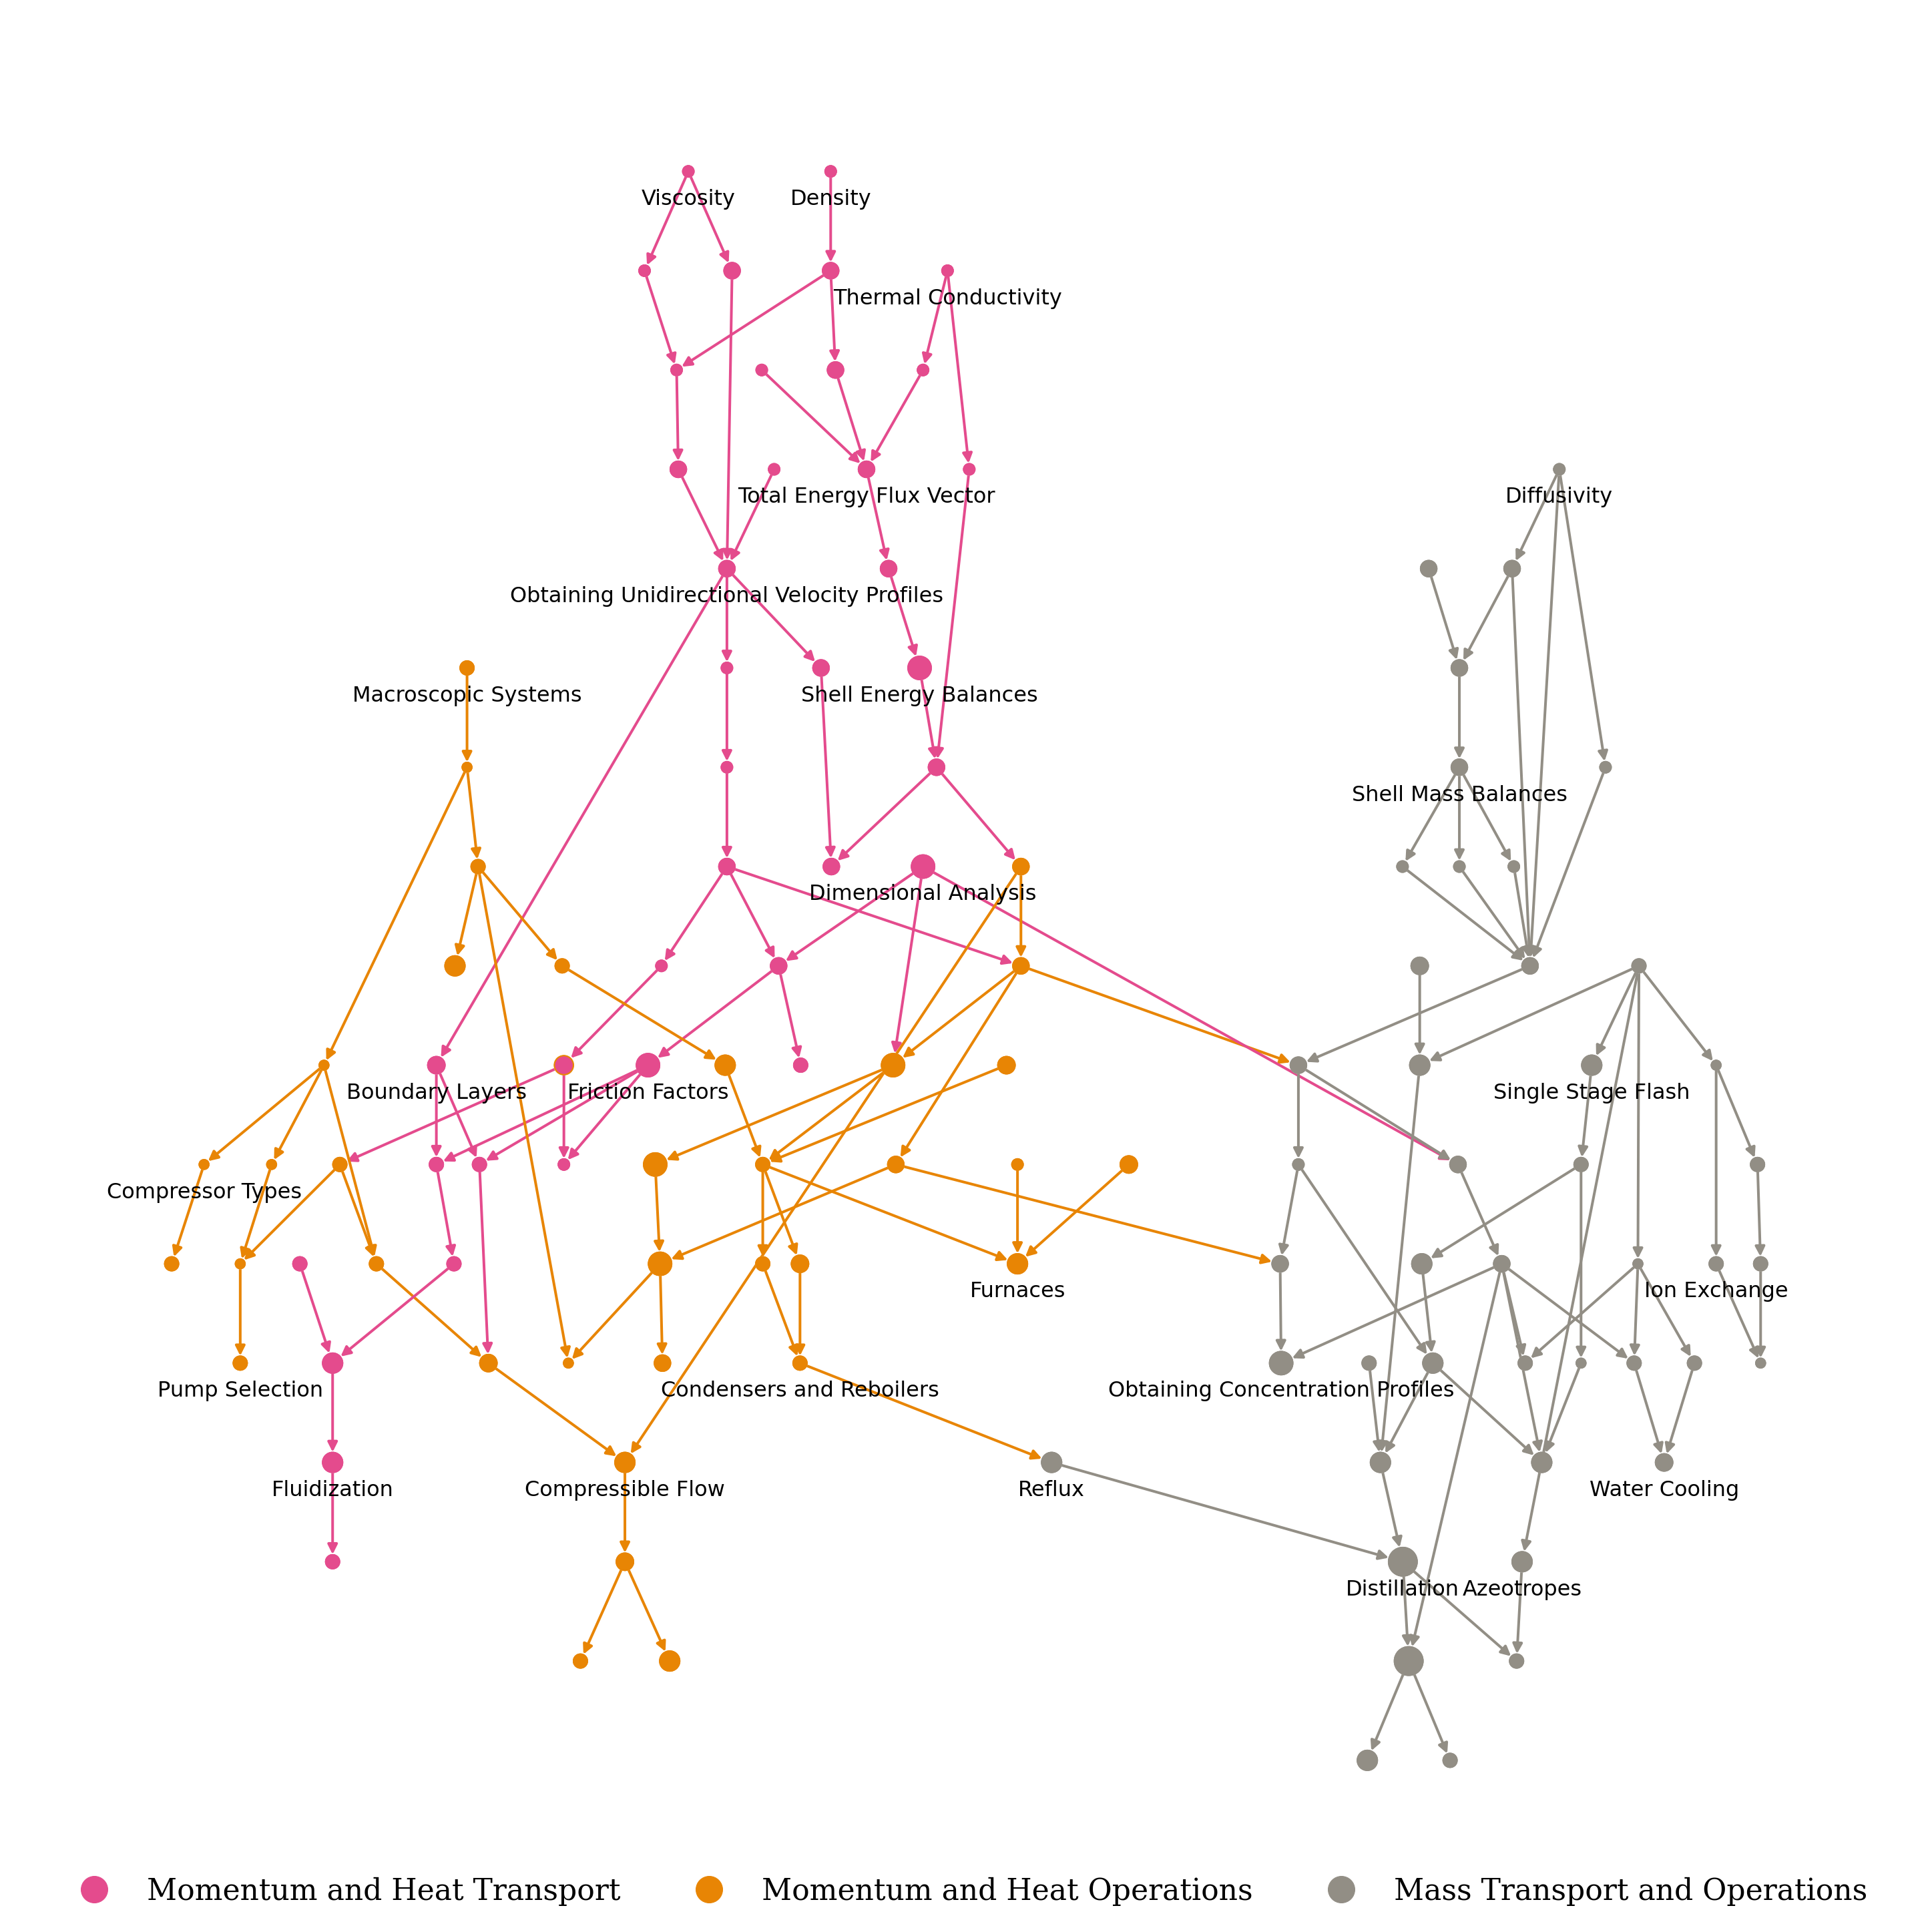

In [12]:
(topic_modules, topic_module_sizes, module_size, module_review_sizes, module_reviewed_topics) = process_modules(modules,module_reviews)

module_names = {0:'Momentum and Heat Transport',1:'Momentum and Heat Operations',2:'Mass Transport and Operations'}

n_modules = len(modules)
colors = ['#e44b8d','#e88504','#928e85','#000000']
module_colors = dict(zip(np.arange(0,n_modules,1),colors))

module_figure = graph_module_nodes(pos_base,module_colors,topic_modules,topic_module_sizes,"../Transport Graphs/Transport Topics-Sequenced Modules.pdf")

nodes_to_label = ['Distillation','Viscosity','Density','Thermal Conductivity','Diffusivity','Dimensional Analysis','Compressor Types','Macroscopic Systems','Boundary Layers','Friction Factors','Furnaces','Distillation','Single Stage Flash','Azeotropes','Adsoprtion Equipment','Obtaining Concentration Profiles','Water Cooling','Reflux','Compressible Flow','Obtaining Unidirectional Velocity Profiles','Total Energy Flux Vector','Condensers and Reboilers','Shell Mass Balances','Fluidization','Pump Selection','Ion Exchange','Shell Energy Balances']
labels_to_display = {node: node for node in nodes_to_label if node in graph.nodes}
labels = nx.draw_networkx_labels(graph, label_pos,labels=labels_to_display, font_size=32, font_family='sans-serif')

legend_elements = [Line2D([0], [0], marker='o', color=module_color, label=module_names[module], lw=0,markerfacecolor=module_color, markersize=40) for module,module_color in module_colors.items()]
font_props = fm.FontProperties(family='serif', size=44)
module_figure.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=3,prop=font_props)
module_figure.savefig("../Transport Graphs/Transport Topics-Sequenced Modules.pdf",format="pdf")

In [13]:
for i in graph.nodes():
    net.get_node(i)['borderWidth'] = 0
    net.get_node(i)['color'] = module_colors[topic_modules[i][0]]
    if i in reviewed_topics:
        net.get_node(i)['borderWidth'] = (sum(topic_module_sizes[i]) - topic_sizes[i])*50

net.save_graph('../Transport Graphs/Transport Topics-Sequenced Modules.html')

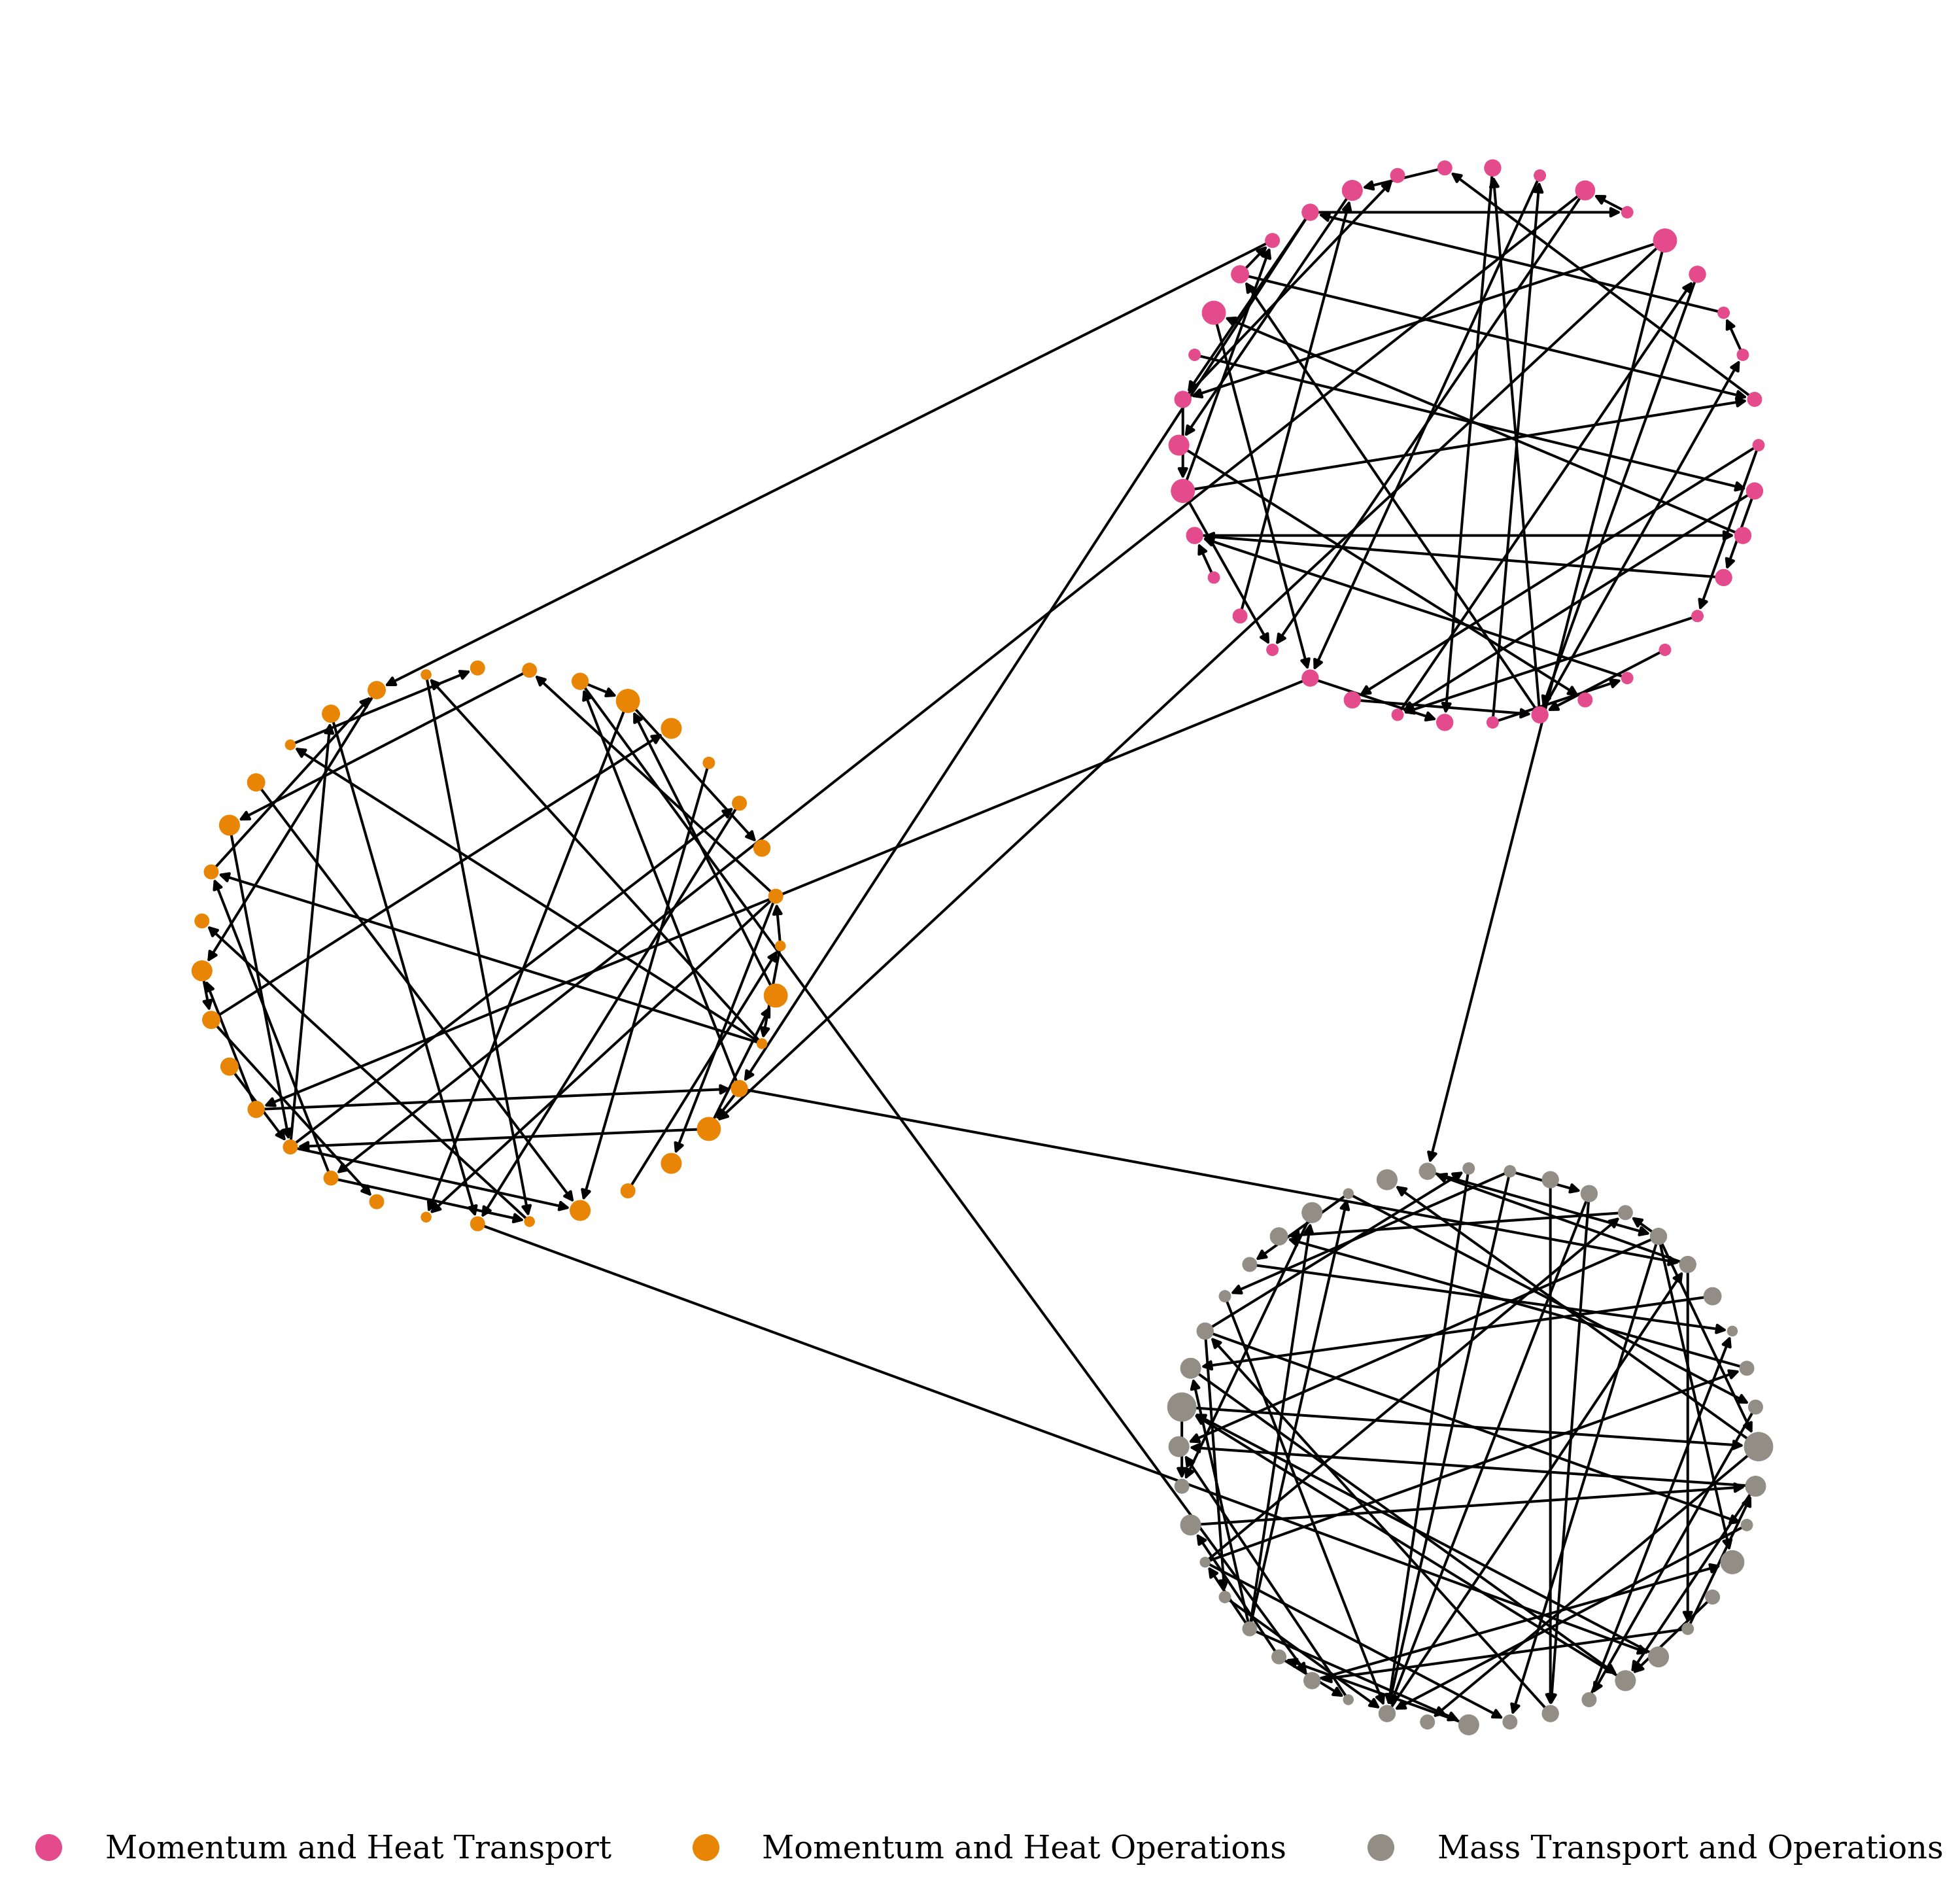

In [14]:
hypergraph = nx.DiGraph()
for k, (i, j) in enumerate(graph.edges()):
    p = topic_modules[i][0]
    q = topic_modules[j][0]
    if p != q:
        hypergraph.add_edge(p, q)

hypergraph_pos = nx.nx_agraph.graphviz_layout(hypergraph, prog='dot')

pos_nodes = dict()
for topics in modules:
    subgraph = graph.subgraph(topics)
    pos_subgraph = nx.circular_layout(subgraph)
    pos_nodes.update(pos_subgraph)

pos_module = dict()
for topics in list(course_topics.values()):
    for i in topics:
        pos_module[i] = (hypergraph_pos[topic_modules[i][0]][0] + 8*pos_nodes[i][0], 
                       hypergraph_pos[topic_modules[i][0]][1] + 40*pos_nodes[i][1]) 

node_size = [sum(topic_module_sizes[i]) for i in graph.nodes()]
modules_figure_grouped = plt.figure(figsize=(40,40))

nx.draw(graph, pos_module, node_size=[8000*v for v in node_size], node_color=[module_colors[topic_modules[i][0]] for i in graph.nodes()], arrowsize=30, width=4, edge_color='#000000')

legend_elements = [Line2D([0], [0], marker='o', color=module_colors[t], label=module_names[t], lw=0,markerfacecolor=module_colors[t], markersize=40) for t in module_names.keys()]
font_props = fm.FontProperties(family='serif', size=48)
modules_figure_grouped.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=3,prop=font_props)

modules_figure_grouped.savefig("../Transport Graphs/Transport Topics-Sequenced Modules Grouped.pdf",format="pdf")

# Comparision

In [15]:
print(sum(credits))
print(credits)
print(round(nx.community.modularity(graph,list(course_topics.values())),3))
print(round(calc_modularity(list(course_topics.values())),3))
print(len(reviewed_topics))
print(round(total_review_size(topic_course_sizes),3))

10
[4, 3, 3]
0.526
0.446
16
0.9


In [16]:
print(round(sum(module_size),2))
print([round(value, 2) for value in module_size])
print(round(nx.community.modularity(graph,modules),3))
print(round(modularity,3))
print(len(module_reviewed_topics))
print(round(total_review_size(topic_module_sizes),3))

9.13
[2.73, 2.76, 3.64]
0.599
0.47
1
0.03


# Animations

In [17]:
import imageio

def hex_to_rgb(value):
   value = value.lstrip('#')
   lv = len(value)
   return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_hex(rgb):
   return '#%02x%02x%02x' % rgb


def weighted_color(color1, weight1, color2, weight2):
   rgb1 = hex_to_rgb(color1)
   rgb2 = hex_to_rgb(color2)

   weighted = lambda x, y: round((weight1*x+weight2*y))

   new_rgb = ()

   for i in range(len(rgb1)):
      new_rgb += (weighted(rgb1[i], rgb2[i]),)
       
   return rgb_to_hex(new_rgb)

In [34]:
frames = 50 # * 2
end_frames = 15 # * 3
fig_size = (10,10)
fs_title = 16
fs_legend = 12
legend_size = 10
node_scale = 750
arrow_size = 8
edge_width = 1

plt.ioff()

font_props = fm.FontProperties(family='serif', size=fs_legend)

with imageio.get_writer('../Animations/Transport Types to Courses to Modules.gif', mode='I') as writer:
    
    fig, ax = plt.subplots(figsize=fig_size)
    nx.draw(graph, pos_base, ax=ax, with_labels=False, arrowsize=arrow_size,width=edge_width, node_color=[type_colors[topic_type[i][0]] for i in graph.nodes()], 
            node_size=[node_scale*v for v in node_size], edge_color='#D3D3D3')
    legend_elements = [Line2D([0], [0], marker='o', color=type_colors[t], label=t, lw=0,markerfacecolor=type_colors[t], markersize=legend_size) for t in names]
    fig.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=5,prop=font_props)
    plt.title('Transport Topics by Type', fontsize=fs_title, family='serif')
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    
    for i in range(end_frames):
        writer.append_data(image)
    
    for i in range(frames):
        fig, ax = plt.subplots(figsize=fig_size)
        pos_image = {}
        for node in graph.nodes():
            x = ((frames-i)/frames) * pos_base[node][0] + (i/frames) * pos_course[node][0]
            y = ((frames-i)/frames) * pos_base[node][1] + (i/frames) * pos_course[node][1]
            pos_image[node] = (x, y)
        
        nx.draw(graph, pos_image, ax=ax, with_labels=False, arrowsize=arrow_size,width=edge_width, node_color=[type_colors[topic_type[i][0]] for i in graph.nodes()], 
                node_size=[node_scale*v for v in node_size], edge_color='#D3D3D3')
        legend_elements = [Line2D([0], [0], marker='o', color=type_colors[t], label=t, lw=0,markerfacecolor=type_colors[t], markersize=legend_size) for t in names]
        fig.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=5,prop=font_props)
        plt.title('Current Transport Courses', fontsize=fs_title, family='serif')
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        writer.append_data(image)
        
    fig, ax = plt.subplots(figsize=fig_size)
    nx.draw(graph, pos_course, ax=ax, with_labels=False, arrowsize=arrow_size,width=edge_width, node_color=[type_colors[topic_type[i][0]] for i in graph.nodes()], 
            node_size=[node_scale*v for v in node_size], edge_color='#D3D3D3')
    legend_elements = [Line2D([0], [0], marker='o', color=type_colors[t], label=t, lw=0,markerfacecolor=type_colors[t], markersize=legend_size) for t in names]
    fig.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=5,prop=font_props)
    plt.title('Current Transport Courses', fontsize=fs_title, family='serif')
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    
    for i in range(end_frames):
        writer.append_data(image)

    for i in range(frames):
        fig, ax = plt.subplots(figsize=fig_size)
        pos_image = {}
        for node in graph.nodes():
            x = ((frames-i)/frames) * pos_course[node][0] + (i/frames) * pos_module[node][0]
            y = ((frames-i)/frames) * pos_course[node][1] + (i/frames) * pos_module[node][1]
            pos_image[node] = (x, y)
        
        nx.draw(graph, pos_image, ax=ax, with_labels=False, arrowsize=arrow_size,width=edge_width, node_color=[type_colors[topic_type[i][0]] for i in graph.nodes()], 
                node_size=[node_scale*v for v in node_size], edge_color='#D3D3D3')
        legend_elements = [Line2D([0], [0], marker='o', color=type_colors[t], label=t, lw=0,markerfacecolor=type_colors[t], markersize=legend_size) for t in names]
        fig.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=5,prop=font_props)
        plt.title('Maximizing Modularity', fontsize=fs_title, family='serif')
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        writer.append_data(image)
        
    fig, ax = plt.subplots(figsize=fig_size)
    nx.draw(graph, pos_module, ax=ax, with_labels=False, arrowsize=arrow_size,width=edge_width, node_color=[type_colors[topic_type[i][0]] for i in graph.nodes()], 
            node_size=[node_scale*v for v in node_size], edge_color='#D3D3D3')
    legend_elements = [Line2D([0], [0], marker='o', color=type_colors[t], label=t, lw=0,markerfacecolor=type_colors[t], markersize=legend_size) for t in names]
    fig.legend(handles=legend_elements, frameon=False, loc = "lower center", ncol=5,prop=font_props)
    plt.title('New Transport Modules', fontsize=fs_title, family='serif')
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    
    for i in range(end_frames):
        writer.append_data(image)